# Benchmark for Clustering

In [154]:
"""Load/import helper functions"""

import time
import random
from LocalPopular import locally_popular_clustering, extract_labels_from_communities, time_tester, calculate_scores_clustering, \
    locally_popular_clustering_with_euclid_graphs

from GraphFunctions import generate_agents, calculate_euclidian_relationships, create_graph, \
    my_make_circles, create_graphs_euclid, create_graphs_kNN, \
    generate_graph,create_graphs_hop_distance, create_graphs_hop_distance_abs,randomize_graph_pos_labels

from PlotHelperFunctions import plot_clustering, plot_stuff

from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_moons, load_breast_cancer, load_iris
from sklearn.metrics import rand_score
import numpy as np
import networkx as nx
from scipy.spatial import distance

from community_detection.leiden import leiden
from community_detection.louvain import louvain
from community_detection.quality_functions import CPM, Modularity



## Create Graphs

In [158]:
repetitions = 1    #Number of random isomorph permutation for each graph


moon_agents,moon_truth = make_moons(n_samples=300, noise=0.05)
moon_perm_agents = []
moon_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_pos_labels(moon_agents,moon_truth)
    moon_perm_agents += [g]
    moon_perm_truth += [t]



circle_agents, circle_truth = my_make_circles(300)

circle_perm_agents = []
circle_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_pos_labels(circle_agents,circle_truth)
    circle_perm_agents += [g]
    circle_perm_truth += [t]

cancer = load_breast_cancer()

cancer_agents = cancer['data']
cancer_truth = cancer['target']

cancer_perm_agents = []
cancer_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_pos_labels(cancer_agents,cancer_truth)
    cancer_perm_agents += [g]
    cancer_perm_truth += [t]

iris = load_iris()
iris_agents = iris['data']
iris_truth = iris['target']


iris_perm_agents = []
iris_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_pos_labels(iris_agents,iris_truth)
    iris_perm_agents += [g]
    iris_perm_truth += [t]


## Run the algorithms


## Gather the numbers

We can use the collected_data dictionairy to build a table for better comparison


In [181]:
import itertools
import timeit
import pandas as pd
import numbers

dfs = []
labels = [(0.2,0.2), (0.25,0.35),(0.4,0.4)]

for treshold in labels:
    collected_data = {}
    for repetitions in range(10):
        f = treshold[0]   #f-bound
        e = treshold[1]   
        data = [ moon_perm_agents,circle_perm_agents,cancer_perm_agents,iris_perm_agents]
        expected_clusters = [2,3,2,3]
        graph_names = ['Moons','My 3 Circles', 'Cancer', 'Iris']
        graph_truths =  [moon_perm_truth,circle_perm_truth,cancer_perm_truth,iris_perm_truth]
        
        
        kmeans = lambda agents, clusters: KMeans(n_clusters = clusters).fit_predict(agents)
        dbscan = lambda agents, clusters: DBSCAN(eps=0.2, min_samples=5).fit_predict(agents)
        
        kmeans_out = None
        dbscan_out = None
        
        lp_a_b =lambda agents, initial_clustering, pre: locally_popular_clustering_with_euclid_graphs(agents, f, e, initial_clustering,mode='B',pre=pre)
        lp_a_f =lambda agents, initial_clustering, pre: locally_popular_clustering_with_euclid_graphs(agents, f, e, initial_clustering,mode='F',pre=pre)
        lp_a_e =lambda agents, initial_clustering, pre: locally_popular_clustering_with_euclid_graphs(agents, f, e, initial_clustering,mode='E',pre=pre)
        
        algorithms = [ kmeans, dbscan,lp_a_b,lp_a_f,lp_a_e]
        algo_names = [ 'kmeans', 'dbscan','LP (Balanced) Heuristic',\
                       'LP (Friend-Oriented) Heuristic','LP (Enemy-Averse) Heuristic']
        is_lp_heuristic = [False,False,True, True, True]
    
    
        for ((graph, g_name,clusters,truth), (algo, a_name,lp_heuristic)) in \
            itertools.product(zip(data, graph_names, expected_clusters,graph_truths), zip(algorithms, algo_names,is_lp_heuristic)):
        
                
            agents = graph
        
            if lp_heuristic:
                # start with everyone alone
                a_name_modified = a_name + ' starting with everyone alone'
                print(f"Running {a_name_modified} on {g_name} … ", end='')
                test_callable = lambda a: list(algo(a,len(agents[0]),None).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                
                scores = calculate_scores_clustering(outputs,truth,agents)
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
                # start with random clustering 
        
                a_name_modified = a_name + ' starting with predicted number of clusters'
                print(f"Running {a_name_modified} on {g_name} … ", end='')
                test_callable = lambda a: list(algo(a,clusters,None).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,agents)
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
        
                # start with the output of k-means
                a_name_modified = a_name + ' starting with the output of k-means'
                print(f"Running {a_name_modified} on {g_name} … ", end='')
                test_callable = lambda a: list(algo(a,clusters,kmeans).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,agents)
        
                rand_score_with_init = sum(rand_score(out, k) for out, k in zip(outputs, kmeans_out)) / len(outputs)
                scores['Rand Score with initial clustering'] = rand_score_with_init
                
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
                # start with the output of dbscan
                a_name_modified = a_name + ' starting with the output of dbscan'
                print(f"Running {a_name_modified} on {g_name} … ", end='')
                test_callable = lambda a: list(algo(a,clusters,kmeans).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
        
                rand_score_with_init = sum(rand_score(out, db) for out, db in zip(outputs, dbscan_out)) / len(outputs)
                scores['Rand Score with initial clustering'] = rand_score_with_init
                
                scores = calculate_scores_clustering(outputs,truth,agents)
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
                    
            else:
        
                print(f"Running {a_name} on {g_name} … ", end='')
                test_callable = lambda a : algo(a, clusters)
                    
                times,outputs = time_tester(test_callable,graph)
                if(algo == kmeans):
                    kmeans_out = outputs
                if(algo == dbscan):
                    dbscan_out = outputs
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,agents)
                scores['Time'] = avg_time
                
                if (a_name, g_name) not in collected_data:
                    collected_data[(a_name, g_name)] = []
                collected_data[(a_name, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
    
       
    records = []

    for (method, dataset), metrics_list in collected_data.items():
        record = {'Method': method, 'Dataset': dataset}
        keys = metrics_list[0].keys()
        for key in keys:
            # check if this metric is numeric
            if isinstance(metrics_list[0][key], numbers.Number):
                values = [m[key] for m in metrics_list]
                mean = sum(values) / len(values)
                std = (sum((v - mean) ** 2 for v in values) / len(values)) ** 0.5
                record[key] = (mean, std)
            else:
                # if not numeric (e.g., a string), just copy one of them
                record[key] = metrics_list[0][key]
        records.append(record)
    
    df = pd.DataFrame(records)
    
    dfs.append(df)

dfs[0].head()

Running kmeans on Moons … execution time: ~ 0.016643 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.4860019978084737
Davies Bouldin Score : ~ 0.7827761048105507
Time : ~ 0.016643300012219697
Running dbscan on Moons … execution time: ~ 0.007295 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.0072954000206664205
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 6.944411 seconds.
Rand Index : ~ 0.6408472686733556
Silhouette Score : ~ 0.44702912929938815
Davies Bouldin Score : ~ 0.6062919608328129
Time : ~ 6.944410500000231
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.585361 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.5853606000018772
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.504944 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5049435000109952
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.509636 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.5096358000009786
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.126874 seconds.
Rand Index : ~ 0.641783723522854
Silhouette Score : ~ 0.44245577501935807
Davies Bouldin Score : ~ 0.6090178019369851
Time : ~ 8.126873600005638
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.541349 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.5413485000026412
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.543940 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5439401000039652
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.497196 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.49719640001421794
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 9.591843 seconds.
Rand Index : ~ 0.6408472686733556
Silhouette Score : ~ 0.44702912929938815
Davies Bouldin Score : ~ 0.6062919608328129
Time : ~ 9.59184280000045
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.552659 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.5526592999813147
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.503434 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4863815282871231
Davies Bouldin Score : ~ 0.782813114977769
Rand Score with initial clustering : ~ 0.9867112597547381
Time : ~ 0.5034344999876339
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.501016 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4863815282871231
Davies Bouldin Score : ~ 0.782813114977769
Time : ~ 0.501015699992422
Running kmeans on My 3 Circles … execution time: ~ 0.005856 seconds.
Rand Index : ~ 0.7449944258639911
Silhouette Score : ~ 0.39686520842521866
Davies Bouldin Score : ~ 0.8831944448378168
Time : ~ 0.005856400006450713
Running dbscan on My 3 Circles … execution time: ~ 0.003719 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0037192999734543264
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.964427 seconds.
Rand Index : ~ 0.7127759197324415
Silhouette Score : ~ 0.2934071435411038
Davies Bouldin Score : ~ 0.7082807038318141
Time : ~ 7.9644272000005
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.604979 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.6049787999945693
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.592534 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Rand Score with initial clustering : ~ 0.7710144927536232
Time : ~ 0.5925335999927483
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.519614 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Time : ~ 0.5196137000166345
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.115573 seconds.
Rand Index : ~ 0.711705685618729
Silhouette Score : ~ 0.28045280663437955
Davies Bouldin Score : ~ 0.7120932492493377
Time : ~ 7.1155725000135135
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.550145 seconds.
Rand Index : ~ 0.6708361204013378
Silhouette Score : ~ 0.22929949893121465
Davies Bouldin Score : ~ 8.738607379760012
Time : ~ 0.550144899985753
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.513049 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Rand Score with initial clustering : ~ 0.7710144927536232
Time : ~ 0.5130493000033312
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.583189 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Time : ~ 0.5831888999964576
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.076529 seconds.
Rand Index : ~ 0.7024080267558528
Silhouette Score : ~ 0.3123944070702664
Davies Bouldin Score : ~ 0.6465432738498906
Time : ~ 8.076528800011147
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.631754 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.6317543000041042
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.519227 seconds.
Rand Index : ~ 0.7604236343366778
Silhouette Score : ~ 0.3808651397584003
Davies Bouldin Score : ~ 1.021302805699543
Rand Score with initial clustering : ~ 0.7125529542920848
Time : ~ 0.5192269000108354
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.559604 seconds.
Rand Index : ~ 0.6709698996655519
Silhouette Score : ~ 0.22947177351974116
Davies Bouldin Score : ~ 8.757391791571472
Time : ~ 0.5596042000106536
Running kmeans on Cancer … execution time: ~ 0.007032 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.007032099994830787
Running dbscan on Cancer … execution time: ~ 0.007141 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.007140700006857514
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 53.201967 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 53.20196710000164
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.230944 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 2.230944200011436
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.943449 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.9434490999847185
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.909763 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.9097633000055794
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 58.291545 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354525
Davies Bouldin Score : ~ 0.424320723095177
Time : ~ 58.291545100015355
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.186850 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 2.1868501999997534
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.786326 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.78632590000052
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.775651 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.775651400006609
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 52.636862 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 52.636861599981785
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.835842 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.835842100001173
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.798739 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.7987387999892235
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.679550 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.679550000000745
Running kmeans on Iris … execution time: ~ 0.004496 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628489
Time : ~ 0.004496199981076643
Running dbscan on Iris … execution time: ~ 0.001791 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.0017909999878611416
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.078832 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 1.078831800026819
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.724488 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.2136177965126773
Time : ~ 0.7244880000071134
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … execution time: ~ 0.169517 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.16951680000056513
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.173408 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.17340770000009798
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.879243 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 0.879243100003805
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.140518 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.2136177965126773
Time : ~ 0.14051750002545305
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.148032 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.14803209999809042
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.143350 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.1433501000283286
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.885772 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 0.885771700006444
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.137408 seconds.
Rand Index : ~ 0.8021476510067114
Silhouette Score : ~ 0.5139053060063954
Davies Bouldin Score : ~ 1.1891407870131

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.140535 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.14053549998789094
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.134001 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.1340014000015799
Running kmeans on Moons … execution time: ~ 0.004292 seconds.
Rand Index : ~ 0.6237458193979933
Silhouette Score : ~ 0.48522467140389725
Davies Bouldin Score : ~ 0.7831149496437956
Time : ~ 0.004292400000849739
Running dbscan on Moons … execution time: ~ 0.002576 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.002575800026534125
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.992220 seconds.
Rand Index : ~ 0.6408472686733556
Silhouette Score : ~ 0.44702912929938815
Davies Bouldin Score : ~ 0.6062919608328129
Time : ~ 7.992220499989344
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.459911 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.45991080001113005
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.457689 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9671125975473801
Time : ~ 0.4576891000033356
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.527019 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.527018799999496
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.293115 seconds.
Rand Index : ~ 0.641783723522854
Silhouette Score : ~ 0.44245577501935807
Davies Bouldin Score : ~ 0.6090178019369851
Time : ~ 8.293114800006151
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.442836 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.4428355000272859
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.506975 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9671125975473801
Time : ~ 0.5069745000218973
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.414640 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4146404000057373
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.377237 seconds.
Rand Index : ~ 0.6408472686733556
Silhouette Score : ~ 0.44702912929938815
Davies Bouldin Score : ~ 0.6062919608328129
Time : ~ 8.377236800006358
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.605039 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.6050394999911077
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.495555 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4863815282871231
Davies Bouldin Score : ~ 0.782813114977769
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.495554599998286
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.570234 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4863815282871231
Davies Bouldin Score : ~ 0.782813114977769
Time : ~ 0.5702341999858618
Running kmeans on My 3 Circles … execution time: ~ 0.007113 seconds.
Rand Index : ~ 0.7472463768115942
Silhouette Score : ~ 0.39534014597588746
Davies Bouldin Score : ~ 0.8852824139706508
Time : ~ 0.0071127999981399626
Running dbscan on My 3 Circles … execution time: ~ 0.003732 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.003731600008904934
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.552937 seconds.
Rand Index : ~ 0.7127759197324415
Silhouette Score : ~ 0.2934071435411038
Davies Bouldin Score : ~ 0.7082807038318141
Time : ~ 7.552936799998861
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.544525 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.5445245000009891
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.441175 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Rand Score with initial clustering : ~ 0.7690301003344482
Time : ~ 0.4411754999891855
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.541182 seconds.
Rand Index : ~ 0.6769453734671126
Silhouette Score : ~ 0.26635896101702516
Davies Bouldin Score : ~ 3.6955485017568974
Time : ~ 0.5411821999878157
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.376483 seconds.
Rand Index : ~ 0.711705685618729
Silhouette Score : ~ 0.28045280663437955
Davies Bouldin Score : ~ 0.7120932492493377
Time : ~ 7.376483300002292
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.530624 seconds.
Rand Index : ~ 0.6708361204013378
Silhouette Score : ~ 0.22929949893121465
Davies Bouldin Score : ~ 8.738607379760012
Time : ~ 0.5306236000033095
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.502901 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Rand Score with initial clustering : ~ 0.7690301003344482
Time : ~ 0.5029014000028837
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.531267 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Time : ~ 0.5312666999816429
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 6.811797 seconds.
Rand Index : ~ 0.7024080267558528
Silhouette Score : ~ 0.3123944070702664
Davies Bouldin Score : ~ 0.6465432738498906
Time : ~ 6.8117973000044
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.521914 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.5219135000079405
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.576971 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Rand Score with initial clustering : ~ 0.7576588628762542
Time : ~ 0.5769706999999471
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.505315 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.5053153999906499
Running kmeans on Cancer … execution time: ~ 0.006460 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.006460200005676597
Running dbscan on Cancer … execution time: ~ 0.005260 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005260100006125867
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 50.487621 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 50.48762090000673
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.042274 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 2.042273999977624
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.711114 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.7111135000013746
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.780861 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.7808607000042684
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.649176 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354525
Davies Bouldin Score : ~ 0.424320723095177
Time : ~ 56.64917619997868
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.873234 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.8732337999972515
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.879803 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.879803499992704
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.015724 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 2.0157240999978967
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 51.322269 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 51.322268899995834
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.875066 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.875066099979449
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.792687 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.7926867999776732
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.531843 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.5318425000004936
Running kmeans on Iris … execution time: ~ 0.004219 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628489
Time : ~ 0.004218799993395805
Running dbscan on Iris … execution time: ~ 0.001834 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.001833599992096424
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.889573 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 0.8895728999923449
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.157900 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.2136177965126773
Time : ~ 0.15790029999334365
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.146281 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.14628079999238253
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.147251 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.14725070001441054
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.595622 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 1.5956215000187512
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.154609 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.21361779651

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.144363 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.14436259999638423
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.159327 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.15932659999816678
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.082795 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 1.082795000023907
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.162400 seconds.
Rand Index : ~ 0.8021476510067114
Silhouette Score : ~ 0.5139053060063954
Davies Bouldin Score : ~ 1.189140787013

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.184700 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.18470030001481064
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.171527 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.17152699999860488
Running kmeans on Moons … execution time: ~ 0.004411 seconds.
Rand Index : ~ 0.6237458193979933
Silhouette Score : ~ 0.48522467140389725
Davies Bouldin Score : ~ 0.7831149496437956
Time : ~ 0.00441069999942556
Running dbscan on Moons … execution time: ~ 0.003223 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.003223400010028854
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.902747 seconds.
Rand Index : ~ 0.6408472686733556
Silhouette Score : ~ 0.44702912929938815
Davies Bouldin Score : ~ 0.6062919608328129
Time : ~ 7.902747400017688
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.564488 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.5644877000013366
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.504618 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9671125975473801
Time : ~ 0.5046176000032574
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.513349 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.5133486999839079
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 7.728268 seconds.
Rand Index : ~ 0.641783723522854
Silhouette Score : ~ 0.44245577501935807
Davies Bouldin Score : ~ 0.6090178019369851
Time : ~ 7.728268300008494
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.540049 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.5400493000051938
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.484161 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9671125975473801
Time : ~ 0.4841606999980286
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.489526 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.48952569998800755
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 6.690236 seconds.
Rand Index : ~ 0.6408472686733556
Silhouette Score : ~ 0.44702912929938815
Davies Bouldin Score : ~ 0.6062919608328129
Time : ~ 6.69023589999415
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.483269 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.483268699987093
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.431401 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4863815282871231
Davies Bouldin Score : ~ 0.782813114977769
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.431400700006634
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.507285 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4863815282871231
Davies Bouldin Score : ~ 0.782813114977769
Time : ~ 0.5072848999989219
Running kmeans on My 3 Circles … execution time: ~ 0.006703 seconds.
Rand Index : ~ 0.7946042363433667
Silhouette Score : ~ 0.35911896900288365
Davies Bouldin Score : ~ 0.9891648441744656
Time : ~ 0.006703399994876236
Running dbscan on My 3 Circles … execution time: ~ 0.003518 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.003518299985444173
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.825365 seconds.
Rand Index : ~ 0.7127759197324415
Silhouette Score : ~ 0.2934071435411038
Davies Bouldin Score : ~ 0.7082807038318141
Time : ~ 7.825365299999248
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.525488 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.5254875000100583
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.522350 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Rand Score with initial clustering : ~ 0.6771683389074693
Time : ~ 0.5223501999862492
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.552372 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Time : ~ 0.5523717000032775
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.296312 seconds.
Rand Index : ~ 0.711705685618729
Silhouette Score : ~ 0.28045280663437955
Davies Bouldin Score : ~ 0.7120932492493377
Time : ~ 7.296312499995111
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.579281 seconds.
Rand Index : ~ 0.6708361204013378
Silhouette Score : ~ 0.22929949893121465
Davies Bouldin Score : ~ 8.738607379760012
Time : ~ 0.5792807999823708
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.464320 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Rand Score with initial clustering : ~ 0.6771683389074693
Time : ~ 0.46431950002443045
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.537503 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Time : ~ 0.537502899998799
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.293340 seconds.
Rand Index : ~ 0.7024080267558528
Silhouette Score : ~ 0.3123944070702664
Davies Bouldin Score : ~ 0.6465432738498906
Time : ~ 7.293340399977751
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.509350 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.5093499000067823
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.473887 seconds.
Rand Index : ~ 0.6709698996655519
Silhouette Score : ~ 0.22947177351974116
Davies Bouldin Score : ~ 8.757391791571472
Rand Score with initial clustering : ~ 0.6777480490523968
Time : ~ 0.47388730000238866
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.476304 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.47630360000766814
Running kmeans on Cancer … execution time: ~ 0.006090 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.006090400012908503
Running dbscan on Cancer … execution time: ~ 0.023781 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.023780599993187934
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 50.415385 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 50.41538469999796
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.850686 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.850686499994481
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.698742 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.6987423000100534
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.616862 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.616861999995308
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 53.976750 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354525
Davies Bouldin Score : ~ 0.424320723095177
Time : ~ 53.97674990000087
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.978617 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.9786170000152197
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.764107 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.7641069999954198
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.533633 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.5336328000121284
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 52.252410 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 52.25240980001399
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.773631 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.7736306999868248
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.953854 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.953853999992134
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.815616 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.8156160999787971
Running kmeans on Iris … execution time: ~ 0.004156 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007523
Time : ~ 0.004155500006163493
Running dbscan on Iris … execution time: ~ 0.001797 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.001796600001398474
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.848116 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 0.8481163999822456
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.159118 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.2136177965126773
Time : ~ 0.15911829998367466
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.157163 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.15716259999317117
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.150080 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.15007969998987392
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.852964 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 0.8529639999906067
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.153745 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.21361779651

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.157090 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.15708989999257028
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.147000 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.14699960002326407
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.846091 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 0.8460913000162691
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.142627 seconds.
Rand Index : ~ 0.8021476510067114
Silhouette Score : ~ 0.5139053060063954
Davies Bouldin Score : ~ 1.18914078701

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.148693 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.1486933999985922
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.150162 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.15016180000384338
Running kmeans on Moons … execution time: ~ 0.004263 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.4860019978084737
Davies Bouldin Score : ~ 0.7827761048105507
Time : ~ 0.004263299982994795
Running dbscan on Moons … execution time: ~ 0.002619 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.0026190000062342733
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.045324 seconds.
Rand Index : ~ 0.6408472686733556
Silhouette Score : ~ 0.44702912929938815
Davies Bouldin Score : ~ 0.6062919608328129
Time : ~ 8.045323700003792
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.477240 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.47723960000439547
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.464636 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.46463559998665005
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.556174 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.5561735999945085
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.199812 seconds.
Rand Index : ~ 0.641783723522854
Silhouette Score : ~ 0.44245577501935807
Davies Bouldin Score : ~ 0.6090178019369851
Time : ~ 8.199811799975578
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.465572 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.46557170001324266
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.452359 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.452359000017168
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.450594 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4505941000243183
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 7.562639 seconds.
Rand Index : ~ 0.6408472686733556
Silhouette Score : ~ 0.44702912929938815
Davies Bouldin Score : ~ 0.6062919608328129
Time : ~ 7.56263949998538
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.509716 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.5097157999989577
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.448505 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4863815282871231
Davies Bouldin Score : ~ 0.782813114977769
Rand Score with initial clustering : ~ 0.9867112597547381
Time : ~ 0.4485051999799907
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.523891 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4863815282871231
Davies Bouldin Score : ~ 0.782813114977769
Time : ~ 0.5238914999936242
Running kmeans on My 3 Circles … execution time: ~ 0.007256 seconds.
Rand Index : ~ 0.7472463768115942
Silhouette Score : ~ 0.39534014597588746
Davies Bouldin Score : ~ 0.8852824139706508
Time : ~ 0.0072564999863971025
Running dbscan on My 3 Circles … execution time: ~ 0.003346 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.003345800010720268
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.602270 seconds.
Rand Index : ~ 0.7127759197324415
Silhouette Score : ~ 0.2934071435411038
Davies Bouldin Score : ~ 0.7082807038318141
Time : ~ 7.602270399976987
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.530355 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.5303547999938019
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.512899 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Rand Score with initial clustering : ~ 0.7690301003344482
Time : ~ 0.5128990999946836
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.457109 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Time : ~ 0.45710900000995025
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.858873 seconds.
Rand Index : ~ 0.711705685618729
Silhouette Score : ~ 0.28045280663437955
Davies Bouldin Score : ~ 0.7120932492493377
Time : ~ 7.8588729000184685
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.535772 seconds.
Rand Index : ~ 0.6708361204013378
Silhouette Score : ~ 0.22929949893121465
Davies Bouldin Score : ~ 8.738607379760012
Time : ~ 0.5357722000044305
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.485687 seconds.
Rand Index : ~ 0.7803790412486065
Silhouette Score : ~ 0.3708889405373152
Davies Bouldin Score : ~ 1.0011112390672208
Rand Score with initial clustering : ~ 0.7022965440356744
Time : ~ 0.4856868999777362
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.458263 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Time : ~ 0.45826319998013787
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 6.839083 seconds.
Rand Index : ~ 0.7024080267558528
Silhouette Score : ~ 0.3123944070702664
Davies Bouldin Score : ~ 0.6465432738498906
Time : ~ 6.839083200000459
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.489187 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.489187099999981
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.516450 seconds.
Rand Index : ~ 0.6709698996655519
Silhouette Score : ~ 0.22947177351974116
Davies Bouldin Score : ~ 8.757391791571472
Rand Score with initial clustering : ~ 0.7664882943143813
Time : ~ 0.516450299997814
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.571050 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.5710496999963652
Running kmeans on Cancer … execution time: ~ 0.005642 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.005642100004479289
Running dbscan on Cancer … execution time: ~ 0.005151 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005150899989530444
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 51.084904 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 51.084903700015275
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.737843 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.7378426999785006
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.886127 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.88612650000141
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.658756 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.6587560000189114
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 59.191681 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354525
Davies Bouldin Score : ~ 0.424320723095177
Time : ~ 59.19168069999432
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.780384 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.7803836000093725
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.621456 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.621455699991202
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.509893 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.509893499984173
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 51.758059 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 51.75805929998751
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.864872 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.8648722000070848
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.775631 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.7756313999998383
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.852478 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.8524779999861494
Running kmeans on Iris … execution time: ~ 0.004207 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007523
Time : ~ 0.004207300022244453
Running dbscan on Iris … execution time: ~ 0.001921 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.0019207000150345266
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.133030 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 1.1330296999949496
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.183269 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.2136177965126773
Time : ~ 0.18326910000178032
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.154389 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.15438890000223182
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.174638 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.17463770002359524
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.810206 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 0.8102061999961734
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.132556 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.21361779651

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.138304 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.13830369999050163
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.145635 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.1456346999912057
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.440627 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 1.4406273000058718
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.156801 seconds.
Rand Index : ~ 0.8021476510067114
Silhouette Score : ~ 0.5139053060063954
Davies Bouldin Score : ~ 1.189140787013

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.147832 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.14783209998859093
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.137781 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.13778129999991506
Running kmeans on Moons … execution time: ~ 0.005006 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.4860019978084737
Davies Bouldin Score : ~ 0.7827761048105507
Time : ~ 0.005006199993658811
Running dbscan on Moons … execution time: ~ 0.002532 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.0025320999848190695
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.309263 seconds.
Rand Index : ~ 0.6408472686733556
Silhouette Score : ~ 0.44702912929938815
Davies Bouldin Score : ~ 0.6062919608328129
Time : ~ 7.309263200004352
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.523564 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.5235639000020456
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.506936 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5069358999899123
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.460984 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4609844000078738
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 7.839769 seconds.
Rand Index : ~ 0.641783723522854
Silhouette Score : ~ 0.44245577501935807
Davies Bouldin Score : ~ 0.6090178019369851
Time : ~ 7.839769100013655
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.514574 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.5145738000283018
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.468759 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.46875939998426475
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.463895 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.46389519999502227
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 5.922642 seconds.
Rand Index : ~ 0.6408472686733556
Silhouette Score : ~ 0.44702912929938815
Davies Bouldin Score : ~ 0.6062919608328129
Time : ~ 5.922642399993492
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.471532 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.47153210002579726
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.465597 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4863815282871231
Davies Bouldin Score : ~ 0.782813114977769
Rand Score with initial clustering : ~ 0.9867112597547381
Time : ~ 0.46559680000063963
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.443743 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4863815282871231
Davies Bouldin Score : ~ 0.782813114977769
Time : ~ 0.4437432999839075
Running kmeans on My 3 Circles … execution time: ~ 0.005826 seconds.
Rand Index : ~ 0.7472463768115942
Silhouette Score : ~ 0.39534014597588746
Davies Bouldin Score : ~ 0.8852824139706508
Time : ~ 0.005826000007800758
Running dbscan on My 3 Circles … execution time: ~ 0.003221 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0032211999932769686
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.269690 seconds.
Rand Index : ~ 0.7127759197324415
Silhouette Score : ~ 0.2934071435411038
Davies Bouldin Score : ~ 0.7082807038318141
Time : ~ 7.269689600012498
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.590025 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.5900245000084396
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.515647 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Rand Score with initial clustering : ~ 0.7690301003344482
Time : ~ 0.5156472999951802
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.457337 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Time : ~ 0.4573372000013478
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.403788 seconds.
Rand Index : ~ 0.711705685618729
Silhouette Score : ~ 0.28045280663437955
Davies Bouldin Score : ~ 0.7120932492493377
Time : ~ 7.403788199997507
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.485640 seconds.
Rand Index : ~ 0.6708361204013378
Silhouette Score : ~ 0.22929949893121465
Davies Bouldin Score : ~ 8.738607379760012
Time : ~ 0.48563960002502427
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.487757 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Rand Score with initial clustering : ~ 0.7690301003344482
Time : ~ 0.4877573999983724
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.544939 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Time : ~ 0.5449393999879248
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.087715 seconds.
Rand Index : ~ 0.7024080267558528
Silhouette Score : ~ 0.3123944070702664
Davies Bouldin Score : ~ 0.6465432738498906
Time : ~ 7.087715300003765
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.525222 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.5252221000264399
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.509823 seconds.
Rand Index : ~ 0.6709698996655519
Silhouette Score : ~ 0.22947177351974116
Davies Bouldin Score : ~ 8.757391791571473
Rand Score with initial clustering : ~ 0.7664882943143813
Time : ~ 0.5098227999988012
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.455632 seconds.
Rand Index : ~ 0.6709698996655519
Silhouette Score : ~ 0.22947177351974116
Davies Bouldin Score : ~ 8.757391791571473
Time : ~ 0.45563229999970645
Running kmeans on Cancer … execution time: ~ 0.006060 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.0060597999836318195
Running dbscan on Cancer … execution time: ~ 0.005888 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005888399988180026
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 49.837664 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 49.83766379998997
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.757885 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.7578848999983165
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.768273 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.7682731000240892
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.705632 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.7056315999943763
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 57.727129 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354525
Davies Bouldin Score : ~ 0.424320723095177
Time : ~ 57.72712940000929
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.881195 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.8811951999960002
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.857051 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.8570512000005692
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.562446 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.5624461999977939
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 53.065528 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 53.06552830000874
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.764037 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.7640371000161394
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.719212 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.719211500021629
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.879819 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.8798194999981206
Running kmeans on Iris … execution time: ~ 0.004242 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007523
Time : ~ 0.0042415999923832715
Running dbscan on Iris … execution time: ~ 0.001927 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.0019274999795015901
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.776910 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 0.7769097999844234
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.156757 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.2136177965126773
Time : ~ 0.15675729999202304
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.140880 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.1408796000177972
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.135246 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.13524579998920672
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.049589 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 1.0495894000050612
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.157167 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.213617796512

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.158161 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.1581605999963358
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.170668 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.17066800000611693
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.759929 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 0.7599293999955989
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.162307 seconds.
Rand Index : ~ 0.8021476510067114
Silhouette Score : ~ 0.5139053060063954
Davies Bouldin Score : ~ 1.189140787013

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.153166 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.15316570000140928
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.146824 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.14682429999811575
Running kmeans on Moons … execution time: ~ 0.004959 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.4860019978084737
Davies Bouldin Score : ~ 0.7827761048105507
Time : ~ 0.004958700010320172
Running dbscan on Moons … execution time: ~ 0.002913 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.0029134000069461763
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.587890 seconds.
Rand Index : ~ 0.6408472686733556
Silhouette Score : ~ 0.44702912929938815
Davies Bouldin Score : ~ 0.6062919608328129
Time : ~ 7.587890000024345
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.539417 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.5394167999911588
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.493157 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.4931569999898784
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.496292 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4962922999984585
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 7.712630 seconds.
Rand Index : ~ 0.641783723522854
Silhouette Score : ~ 0.44245577501935807
Davies Bouldin Score : ~ 0.6090178019369851
Time : ~ 7.71263020002516
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.536022 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.5360216000117362
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.507599 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5075988999742549
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.488278 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4882782000058796
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 7.401775 seconds.
Rand Index : ~ 0.6408472686733556
Silhouette Score : ~ 0.44702912929938815
Davies Bouldin Score : ~ 0.6062919608328129
Time : ~ 7.401775400008773
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.501371 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.5013708999904338
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.467732 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4863815282871231
Davies Bouldin Score : ~ 0.782813114977769
Rand Score with initial clustering : ~ 0.9867112597547381
Time : ~ 0.4677318999893032
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.500582 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4863815282871231
Davies Bouldin Score : ~ 0.782813114977769
Time : ~ 0.5005817000055686
Running kmeans on My 3 Circles … execution time: ~ 0.005902 seconds.
Rand Index : ~ 0.7449944258639911
Silhouette Score : ~ 0.39686520842521866
Davies Bouldin Score : ~ 0.8831944448378167
Time : ~ 0.005902299977606162
Running dbscan on My 3 Circles … execution time: ~ 0.003376 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0033759000070858747
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.775698 seconds.
Rand Index : ~ 0.7127759197324415
Silhouette Score : ~ 0.2934071435411038
Davies Bouldin Score : ~ 0.7082807038318141
Time : ~ 7.775698200013721
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.665974 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.6659739000024274
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.562634 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Rand Score with initial clustering : ~ 0.7710144927536232
Time : ~ 0.5626341000024695
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.497093 seconds.
Rand Index : ~ 0.6769453734671126
Silhouette Score : ~ 0.26635896101702516
Davies Bouldin Score : ~ 3.6955485017568974
Time : ~ 0.4970931000134442
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.507995 seconds.
Rand Index : ~ 0.711705685618729
Silhouette Score : ~ 0.28045280663437955
Davies Bouldin Score : ~ 0.7120932492493377
Time : ~ 7.507995199994184
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.564830 seconds.
Rand Index : ~ 0.6708361204013378
Silhouette Score : ~ 0.22929949893121465
Davies Bouldin Score : ~ 8.738607379760012
Time : ~ 0.5648301999899559
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.509408 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Rand Score with initial clustering : ~ 0.7710144927536232
Time : ~ 0.5094075000088196
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.500961 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Time : ~ 0.5009605999803171
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.460025 seconds.
Rand Index : ~ 0.7024080267558528
Silhouette Score : ~ 0.3123944070702664
Davies Bouldin Score : ~ 0.6465432738498906
Time : ~ 7.460025200009113
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.495570 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.4955703000014182
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.512244 seconds.
Rand Index : ~ 0.6709698996655519
Silhouette Score : ~ 0.22947177351974116
Davies Bouldin Score : ~ 8.757391791571472
Rand Score with initial clustering : ~ 0.7684726867335563
Time : ~ 0.5122440000122879
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.559674 seconds.
Rand Index : ~ 0.6709698996655519
Silhouette Score : ~ 0.22947177351974116
Davies Bouldin Score : ~ 8.757391791571472
Time : ~ 0.559673500014469
Running kmeans on Cancer … execution time: ~ 0.005526 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.005525900021893904
Running dbscan on Cancer … execution time: ~ 0.021787 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.021786600002087653
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 54.044676 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 54.04467620002106
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.091900 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 2.0918995999963954
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.147974 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.1479741999937687
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.997840 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.9978401999978814
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 59.268488 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354525
Davies Bouldin Score : ~ 0.424320723095177
Time : ~ 59.26848769999924
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.261768 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 2.26176839999971
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.160256 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.1602559000020847
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.826636 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.8266362999856938
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 54.723384 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 54.72338449998642
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.116819 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 2.116818599984981
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.645033 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.6450328000064474
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.829268 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.829268100002082
Running kmeans on Iris … execution time: ~ 0.006053 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007523
Time : ~ 0.006052900018403307
Running dbscan on Iris … execution time: ~ 0.001861 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.0018613000283949077
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.926671 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 0.9266713999968488
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.151729 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.2136177965126773
Time : ~ 0.1517286000016611
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.174739 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.1747386000060942
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.165879 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.16587920000893064
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.772074 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 1.772073799977079
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.142804 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.2136177965126

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.152271 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.15227109999977984
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.141738 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.1417383000080008
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.881797 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 0.8817970000091009
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.166247 seconds.
Rand Index : ~ 0.8021476510067114
Silhouette Score : ~ 0.5139053060063954
Davies Bouldin Score : ~ 1.189140787013

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.148542 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.14854160000686534
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.142246 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.1422459000023082
Running kmeans on Moons … execution time: ~ 0.004099 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.4860019978084737
Davies Bouldin Score : ~ 0.7827761048105507
Time : ~ 0.004099000012502074
Running dbscan on Moons … execution time: ~ 0.002944 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.0029439000063575804
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.902199 seconds.
Rand Index : ~ 0.6408472686733556
Silhouette Score : ~ 0.44702912929938815
Davies Bouldin Score : ~ 0.6062919608328129
Time : ~ 7.902199100004509
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.527263 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.5272627999947872
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.506745 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5067450999922585
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.441625 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4416248000052292
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 7.951268 seconds.
Rand Index : ~ 0.641783723522854
Silhouette Score : ~ 0.44245577501935807
Davies Bouldin Score : ~ 0.6090178019369851
Time : ~ 7.95126750000054
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.557829 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.5578285999945365
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.488940 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.4889401000109501
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.501381 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.5013810999807902
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 7.477823 seconds.
Rand Index : ~ 0.6408472686733556
Silhouette Score : ~ 0.44702912929938815
Davies Bouldin Score : ~ 0.6062919608328129
Time : ~ 7.477822999993805
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.477378 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.4773776999791153
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.462745 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4863815282871231
Davies Bouldin Score : ~ 0.782813114977769
Rand Score with initial clustering : ~ 0.9867112597547381
Time : ~ 0.4627452999993693
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.480821 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4863815282871231
Davies Bouldin Score : ~ 0.782813114977769
Time : ~ 0.48082090000389144
Running kmeans on My 3 Circles … execution time: ~ 0.005465 seconds.
Rand Index : ~ 0.782118171683389
Silhouette Score : ~ 0.35517041731891
Davies Bouldin Score : ~ 0.998525309217897
Time : ~ 0.005464899993967265
Running dbscan on My 3 Circles … execution time: ~ 0.003323 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.003322700009448454
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.032971 seconds.
Rand Index : ~ 0.7127759197324415
Silhouette Score : ~ 0.2934071435411038
Davies Bouldin Score : ~ 0.7082807038318141
Time : ~ 8.032971200009342
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.571121 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.5711211000161711
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.492438 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Rand Score with initial clustering : ~ 0.6716387959866221
Time : ~ 0.4924384000187274
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.476664 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Time : ~ 0.47666379998554476
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.636970 seconds.
Rand Index : ~ 0.711705685618729
Silhouette Score : ~ 0.28045280663437955
Davies Bouldin Score : ~ 0.7120932492493377
Time : ~ 7.636969699990004
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.571674 seconds.
Rand Index : ~ 0.6708361204013378
Silhouette Score : ~ 0.22929949893121465
Davies Bouldin Score : ~ 8.738607379760012
Time : ~ 0.5716735000023618
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.539421 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Rand Score with initial clustering : ~ 0.6716387959866221
Time : ~ 0.5394207999925129
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.548225 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Time : ~ 0.5482249000051524
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.287668 seconds.
Rand Index : ~ 0.7024080267558528
Silhouette Score : ~ 0.3123944070702664
Davies Bouldin Score : ~ 0.6465432738498906
Time : ~ 7.28766750000068
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.578898 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.5788982000085525
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.532100 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Rand Score with initial clustering : ~ 0.674180602006689
Time : ~ 0.5321002000127919
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.576205 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.5762047000171151
Running kmeans on Cancer … execution time: ~ 0.005939 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.005938799993600696
Running dbscan on Cancer … execution time: ~ 0.005624 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005624400015221909
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 54.869338 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 54.869338199991034
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.956289 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.956288899993524
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.758581 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.7585805999988224
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.863677 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.863676899985876
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 58.128567 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354525
Davies Bouldin Score : ~ 0.424320723095177
Time : ~ 58.128567100007785
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.073678 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 2.0736777000129223
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.976387 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.9763870000024326
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.918333 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.9183331999811344
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.469141 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 56.46914110000944
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.858001 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.8580009000143036
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.892309 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.892309099988779
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.610638 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.6106377000105567
Running kmeans on Iris … execution time: ~ 0.004336 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628489
Time : ~ 0.004336299985880032
Running dbscan on Iris … execution time: ~ 0.001990 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.001990099990507588
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.451596 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 1.4515962000004947
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.137649 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.2136177965126773
Time : ~ 0.13764899998204783
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.148672 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.14867189998039976
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.134685 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.13468529999954626
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.853567 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 0.8535671999852639
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.157219 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.21361779651

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.143898 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.14389770000707358
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.147200 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.14719980000518262
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.013453 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 1.0134527999907732
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.154704 seconds.
Rand Index : ~ 0.8021476510067114
Silhouette Score : ~ 0.5139053060063954
Davies Bouldin Score : ~ 1.18914078701

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.144808 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.14480820001335815
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.149981 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.14998089999426156
Running kmeans on Moons … execution time: ~ 0.004464 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.4860019978084737
Davies Bouldin Score : ~ 0.7827761048105507
Time : ~ 0.0044639999978244305
Running dbscan on Moons … execution time: ~ 0.002673 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.0026725000061560422
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.940704 seconds.
Rand Index : ~ 0.6408472686733556
Silhouette Score : ~ 0.44702912929938815
Davies Bouldin Score : ~ 0.6062919608328129
Time : ~ 7.940703600004781
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.478584 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.47858399999677204
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.496192 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.4961917999899015
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.499823 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.49982339999405667
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 7.298829 seconds.
Rand Index : ~ 0.641783723522854
Silhouette Score : ~ 0.44245577501935807
Davies Bouldin Score : ~ 0.6090178019369851
Time : ~ 7.298828900005901
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.541918 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.541918299975805
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.475050 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.47505049998289905
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.498270 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4982704999856651
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.725511 seconds.
Rand Index : ~ 0.6408472686733556
Silhouette Score : ~ 0.44702912929938815
Davies Bouldin Score : ~ 0.6062919608328129
Time : ~ 8.725511299999198
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.550265 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.5502653000003193
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.464943 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4863815282871231
Davies Bouldin Score : ~ 0.782813114977769
Rand Score with initial clustering : ~ 0.9867112597547381
Time : ~ 0.4649428999982774
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.512860 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4863815282871231
Davies Bouldin Score : ~ 0.782813114977769
Time : ~ 0.512860200018622
Running kmeans on My 3 Circles … execution time: ~ 0.005749 seconds.
Rand Index : ~ 0.7449944258639911
Silhouette Score : ~ 0.39686520842521866
Davies Bouldin Score : ~ 0.8831944448378167
Time : ~ 0.005749200005084276
Running dbscan on My 3 Circles … execution time: ~ 0.003255 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0032550999894738197
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.735461 seconds.
Rand Index : ~ 0.7127759197324415
Silhouette Score : ~ 0.2934071435411038
Davies Bouldin Score : ~ 0.7082807038318141
Time : ~ 7.735460500000045
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.596829 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.5968285999842919
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.555025 seconds.
Rand Index : ~ 0.6769453734671126
Silhouette Score : ~ 0.26635896101702516
Davies Bouldin Score : ~ 3.6955485017568974
Rand Score with initial clustering : ~ 0.7127313266443701
Time : ~ 0.555025299981935
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.617060 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Time : ~ 0.6170595000148751
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.089445 seconds.
Rand Index : ~ 0.711705685618729
Silhouette Score : ~ 0.28045280663437955
Davies Bouldin Score : ~ 0.7120932492493377
Time : ~ 8.089445200021146
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.533254 seconds.
Rand Index : ~ 0.6708361204013378
Silhouette Score : ~ 0.22929949893121465
Davies Bouldin Score : ~ 8.738607379760012
Time : ~ 0.5332539999799337
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.514027 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Rand Score with initial clustering : ~ 0.7710144927536232
Time : ~ 0.5140267000242602
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.531848 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Time : ~ 0.5318480000132695
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.611823 seconds.
Rand Index : ~ 0.7024080267558528
Silhouette Score : ~ 0.3123944070702664
Davies Bouldin Score : ~ 0.6465432738498906
Time : ~ 7.611822500010021
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.487056 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.4870556000096258
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.513963 seconds.
Rand Index : ~ 0.6709698996655519
Silhouette Score : ~ 0.22947177351974116
Davies Bouldin Score : ~ 8.757391791571472
Rand Score with initial clustering : ~ 0.7684726867335563
Time : ~ 0.5139634000079241
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.458964 seconds.
Rand Index : ~ 0.6709698996655519
Silhouette Score : ~ 0.22947177351974116
Davies Bouldin Score : ~ 8.757391791571472
Time : ~ 0.4589642999926582
Running kmeans on Cancer … execution time: ~ 0.006004 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.006003999995300546
Running dbscan on Cancer … execution time: ~ 0.005906 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005905500001972541
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 52.067922 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 52.06792180001503
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.996895 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.9968949999893084
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.700763 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.7007631000014953
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.852447 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.852447100012796
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 55.721672 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354525
Davies Bouldin Score : ~ 0.424320723095177
Time : ~ 55.72167209998588
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.029579 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 2.02957929999684
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.722288 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.7222877999884076
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.944823 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.9448231999995187
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 53.425667 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 53.42566700000316
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.178381 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 2.178380500001367
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.693288 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.693287500005681
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.453566 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.4535663000133354
Running kmeans on Iris … execution time: ~ 0.004767 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628489
Time : ~ 0.004766599973663688
Running dbscan on Iris … execution time: ~ 0.001806 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.0018060000147670507
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.945494 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 0.9454938000126276
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.150463 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.2136177965126773
Time : ~ 0.15046340000117198
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.151791 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.15179090001038276
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.146440 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.14644000001135282
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.063755 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 1.0637551000108942
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.150574 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.21361779651

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.153301 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.2136177965126773
Rand Score with initial clustering : ~ 0.8120805369127517
Time : ~ 0.15330149998771958
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.143816 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.1438157000229694
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.054451 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 1.0544509000028484
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.165828 seconds.
Rand Index : ~ 0.8021476510067114
Silhouette Score : ~ 0.5139053060063954
Davies Bouldin Score : ~ 1.1891407870

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.168395 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.1683951999875717
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.155179 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.15517939999699593
Running kmeans on Moons … execution time: ~ 0.003904 seconds.
Rand Index : ~ 0.6237458193979933
Silhouette Score : ~ 0.48522467140389725
Davies Bouldin Score : ~ 0.7831149496437956
Time : ~ 0.0039043000142555684
Running dbscan on Moons … execution time: ~ 0.003244 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.003243900020606816
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.201618 seconds.
Rand Index : ~ 0.6408472686733556
Silhouette Score : ~ 0.44702912929938815
Davies Bouldin Score : ~ 0.6062919608328129
Time : ~ 8.201617699989583
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.558026 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.5580259000125807
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.535969 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9671125975473801
Time : ~ 0.535969099990325
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.538578 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.5385777999763377
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 7.885770 seconds.
Rand Index : ~ 0.641783723522854
Silhouette Score : ~ 0.44245577501935807
Davies Bouldin Score : ~ 0.6090178019369851
Time : ~ 7.885769500018796
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.490510 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.49051000000326894
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.482333 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9671125975473801
Time : ~ 0.48233269999036565
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.495005 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4950047000020277
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 7.886243 seconds.
Rand Index : ~ 0.6408472686733556
Silhouette Score : ~ 0.44702912929938815
Davies Bouldin Score : ~ 0.6062919608328129
Time : ~ 7.886243099987041
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.496320 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.4963203999795951
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.558661 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4863815282871231
Davies Bouldin Score : ~ 0.782813114977769
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.5586613000195939
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.461580 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4863815282871231
Davies Bouldin Score : ~ 0.782813114977769
Time : ~ 0.4615795999998227
Running kmeans on My 3 Circles … execution time: ~ 0.005964 seconds.
Rand Index : ~ 0.7449944258639911
Silhouette Score : ~ 0.39686520842521866
Davies Bouldin Score : ~ 0.8831944448378168
Time : ~ 0.005964399984804913
Running dbscan on My 3 Circles … execution time: ~ 0.003550 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0035499999939929694
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.039512 seconds.
Rand Index : ~ 0.7127759197324415
Silhouette Score : ~ 0.2934071435411038
Davies Bouldin Score : ~ 0.7082807038318141
Time : ~ 8.03951179998694
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.624594 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.624594499997329
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.509173 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Rand Score with initial clustering : ~ 0.7710144927536232
Time : ~ 0.5091728000261355
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.553281 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Time : ~ 0.5532808999996632
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.958126 seconds.
Rand Index : ~ 0.711705685618729
Silhouette Score : ~ 0.28045280663437955
Davies Bouldin Score : ~ 0.7120932492493377
Time : ~ 7.9581261000130326
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.578708 seconds.
Rand Index : ~ 0.6708361204013378
Silhouette Score : ~ 0.22929949893121465
Davies Bouldin Score : ~ 8.738607379760012
Time : ~ 0.5787081000162289
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.503780 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Rand Score with initial clustering : ~ 0.7710144927536232
Time : ~ 0.5037795999960508
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.560673 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Time : ~ 0.5606732000014745
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.397552 seconds.
Rand Index : ~ 0.7024080267558528
Silhouette Score : ~ 0.3123944070702664
Davies Bouldin Score : ~ 0.6465432738498906
Time : ~ 7.3975515000056475
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.524288 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.524287500011269
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.555748 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Rand Score with initial clustering : ~ 0.7595540691192865
Time : ~ 0.5557477000111248
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.582526 seconds.
Rand Index : ~ 0.6709698996655519
Silhouette Score : ~ 0.22947177351974116
Davies Bouldin Score : ~ 8.757391791571472
Time : ~ 0.5825255999807268
Running kmeans on Cancer … execution time: ~ 0.005707 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.00570720000541769
Running dbscan on Cancer … execution time: ~ 0.005514 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005514399992534891
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 51.482635 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 51.482634999993024
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.989629 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.989629399991827
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.650515 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.6505153000180144
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.987914 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.9879138999967836
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 55.593891 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354525
Davies Bouldin Score : ~ 0.424320723095177
Time : ~ 55.593890599993756
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.002015 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 2.0020148000039626
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.583930 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.5839295000187121
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.618083 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.6180826999770943
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 50.767927 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 50.76792650000425
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.909522 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.9095223000040278
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.961513 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.961512700014282
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.870321 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.8703208999941126
Running kmeans on Iris … execution time: ~ 0.004357 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628489
Time : ~ 0.004357099998742342
Running dbscan on Iris … execution time: ~ 0.001795 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.001795399992261082
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.437248 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 1.4372483000042848
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.150848 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.2136177965126773
Time : ~ 0.15084799999021925
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.150898 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.15089799999259412
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.150418 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.1504177000024356
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.917366 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 0.9173658000072464
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.139199 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.213617796512

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.153693 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.15369279999868013
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.152304 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.15230380001594312
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.910586 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 0.9105863000149839
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.148312 seconds.
Rand Index : ~ 0.8021476510067114
Silhouette Score : ~ 0.5139053060063954
Davies Bouldin Score : ~ 1.18914078701

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.152223 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.1522228000103496
Running kmeans on Moons … execution time: ~ 0.004482 seconds.
Rand Index : ~ 0.6237458193979933
Silhouette Score : ~ 0.48522467140389725
Davies Bouldin Score : ~ 0.7831149496437956
Time : ~ 0.004482000018469989
Running dbscan on Moons … execution time: ~ 0.002425 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.002425499988021329
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.677462 seconds.
Rand Index : ~ 0.6408472686733556
Silhouette Score : ~ 0.44702912929938815
Davies Bouldin Score : ~ 0.6062919608328129
Time : ~ 7.677461800019955
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.521136 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.521135899994988
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.507569 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9671125975473801
Time : ~ 0.5075687000062317
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.498715 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.49871479999274015
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.235517 seconds.
Rand Index : ~ 0.641783723522854
Silhouette Score : ~ 0.44245577501935807
Davies Bouldin Score : ~ 0.6090178019369851
Time : ~ 8.23551729999599
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.592425 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.5924248999799602
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.475421 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9671125975473801
Time : ~ 0.4754206000070553
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.426286 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.42628630000399426
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.004433 seconds.
Rand Index : ~ 0.6408472686733556
Silhouette Score : ~ 0.44702912929938815
Davies Bouldin Score : ~ 0.6062919608328129
Time : ~ 8.004433200025233
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.466024 seconds.
Rand Index : ~ 0.9291192865105908
Silhouette Score : ~ 0.37260738703679636
Davies Bouldin Score : ~ 1.0328616525194674
Time : ~ 0.4660241999954451
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.499181 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4863815282871231
Davies Bouldin Score : ~ 0.782813114977769
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.4991814000240993
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.428183 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4863815282871231
Davies Bouldin Score : ~ 0.782813114977769
Time : ~ 0.42818329998408444
Running kmeans on My 3 Circles … execution time: ~ 0.006205 seconds.
Rand Index : ~ 0.7472463768115942
Silhouette Score : ~ 0.39534014597588746
Davies Bouldin Score : ~ 0.8852824139706508
Time : ~ 0.006204600009368733
Running dbscan on My 3 Circles … execution time: ~ 0.002974 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.002973700000438839
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 6.789453 seconds.
Rand Index : ~ 0.7127759197324415
Silhouette Score : ~ 0.2934071435411038
Davies Bouldin Score : ~ 0.7082807038318141
Time : ~ 6.789452700002585
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.548995 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.5489945999870542
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.540771 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Rand Score with initial clustering : ~ 0.7690301003344482
Time : ~ 0.5407709999999497
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.571838 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Time : ~ 0.5718378000019584
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.052696 seconds.
Rand Index : ~ 0.711705685618729
Silhouette Score : ~ 0.28045280663437955
Davies Bouldin Score : ~ 0.7120932492493377
Time : ~ 7.052695999998832
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.544552 seconds.
Rand Index : ~ 0.6708361204013378
Silhouette Score : ~ 0.22929949893121465
Davies Bouldin Score : ~ 8.738607379760012
Time : ~ 0.5445515000028536
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.529170 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Rand Score with initial clustering : ~ 0.7690301003344482
Time : ~ 0.5291702999966219
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.558376 seconds.
Rand Index : ~ 0.6716387959866221
Silhouette Score : ~ 0.23314329503240772
Davies Bouldin Score : ~ 8.95848805360277
Time : ~ 0.5583763000031468
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.002969 seconds.
Rand Index : ~ 0.7024080267558528
Silhouette Score : ~ 0.3123944070702664
Davies Bouldin Score : ~ 0.6465432738498906
Time : ~ 7.002968799992232
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.519392 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.5193919000157621
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.539557 seconds.
Rand Index : ~ 0.6709698996655519
Silhouette Score : ~ 0.22947177351974116
Davies Bouldin Score : ~ 8.757391791571472
Rand Score with initial clustering : ~ 0.7664882943143813
Time : ~ 0.5395568000094499
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.545374 seconds.
Rand Index : ~ 0.6702564102564103
Silhouette Score : ~ 0.22583274279179316
Davies Bouldin Score : ~ 8.383007439728758
Time : ~ 0.5453741000092123
Running kmeans on Cancer … execution time: ~ 0.005743 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.005742899986216798
Running dbscan on Cancer … execution time: ~ 0.005350 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005350199993699789
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 50.258847 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 50.258846999990055
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.045481 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 2.0454813999822363
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.469830 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.4698303999903146
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.556776 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.5567756000091322
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 57.169049 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354525
Davies Bouldin Score : ~ 0.424320723095177
Time : ~ 57.169049099989934
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.147323 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 2.14732260000892
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.797557 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.7975572999857832
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.861826 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.8618257999769412
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 51.398067 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.3826830467117156
Time : ~ 51.398067300004186
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.932117 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.9321166000154335
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.702367 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.7023669999907725
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.814800 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.482084628560223
Time : ~ 1.8147996999905445
Running kmeans on Iris … execution time: ~ 0.004159 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007523
Time : ~ 0.0041588000021874905
Running dbscan on Iris … execution time: ~ 0.001814 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.0018139000167138875
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.802818 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 0.8028175000217743
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.143468 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.2136177965126773
Time : ~ 0.14346769999247044
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.148015 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.14801469998201355
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.150740 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.1507401000126265
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.651310 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 1.651310499990359
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.169282 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.2136177965126

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.158613 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.1586134000099264
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.162966 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.16296560000046156
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.096889 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.4408940331525213
Davies Bouldin Score : ~ 0.6945763445749711
Time : ~ 1.096888800006127
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.187500 seconds.
Rand Index : ~ 0.8021476510067114
Silhouette Score : ~ 0.5139053060063954
Davies Bouldin Score : ~ 1.1891407870131

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.167851 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.1678507000033278
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.170853 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103234
Time : ~ 0.17085270001553
Running kmeans on Moons … execution time: ~ 0.005068 seconds.
Rand Index : ~ 0.6237458193979933
Silhouette Score : ~ 0.48522467140389725
Davies Bouldin Score : ~ 0.7831149496437956
Time : ~ 0.005067799997050315
Running dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.003492 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.003491900017252192
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 10.080954 seconds.
Rand Index : ~ 0.6373913043478261
Silhouette Score : ~ 0.46157830501964325
Davies Bouldin Score : ~ 0.769293801991931
Time : ~ 10.080954300006852
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.465279 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.465279099997133
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.464113 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.8523076923076923
Time : ~ 0.46411270002136007
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.420820 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.42081969999708235
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 10.177428 seconds.
Rand Index : ~ 0.6373913043478261
Silhouette Score : ~ 0.46157830501964325
Davies Bouldin Score : ~ 0.769293801991931
Time : ~ 10.177428199996939
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.424108 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.42410750000271946
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.452371 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.8523076923076923
Time : ~ 0.4523707000189461
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.470306 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.47030590000213124
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 9.499281 seconds.
Rand Index : ~ 0.6254849498327759
Silhouette Score : ~ 0.4588458900372957
Davies Bouldin Score : ~ 0.7719755037527964
Time : ~ 9.499280599993654
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.470444 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4704436000029091
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.450210 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.8523076923076923
Time : ~ 0.450210299983155
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.485191 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4851908999844454
Running kmeans on My 3 Circles … execution time: ~ 0.006808 seconds.
Rand Index : ~ 0.7472463768115942
Silhouette Score : ~ 0.39534014597588746
Davies Bouldin Score : ~ 0.8852824139706508
Time : ~ 0.006808100006310269
Running dbscan on My 3 Circles … execution time: ~ 0.003173 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0031732000061310828
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.646528 seconds.
Rand Index : ~ 0.7696989966555184
Silhouette Score : ~ 0.2961134613804406
Davies Bouldin Score : ~ 0.773059596733972
Time : ~ 7.646528199984459
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.484222 seconds.
Rand Index : ~ 0.7642586399108138
Silhouette Score : ~ 0.3718494577744847
Davies Bouldin Score : ~ 0.8720494169848173
Time : ~ 0.4842216999968514
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.506317 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Rand Score with initial clustering : ~ 0.8900557413600891
Time : ~ 0.5063165999890771
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.446362 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Time : ~ 0.446361500013154
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.493520 seconds.
Rand Index : ~ 0.7724191750278707
Silhouette Score : ~ 0.29445873835900543
Davies Bouldin Score : ~ 0.7720446168019277
Time : ~ 7.493519600015134
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.552917 seconds.
Rand Index : ~ 0.7642586399108138
Silhouette Score : ~ 0.3718494577744847
Davies Bouldin Score : ~ 0.8720494169848173
Time : ~ 0.5529174999974202
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.461245 seconds.
Rand Index : ~ 0.7642140468227425
Silhouette Score : ~ 0.3721064267345961
Davies Bouldin Score : ~ 0.8851022778451184
Rand Score with initial clustering : ~ 0.6958974358974359
Time : ~ 0.4612446000101045
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.545723 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Time : ~ 0.5457233000197448
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 6.487236 seconds.
Rand Index : ~ 0.7696989966555184
Silhouette Score : ~ 0.2961134613804406
Davies Bouldin Score : ~ 0.773059596733972
Time : ~ 6.487236099987058
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.507278 seconds.
Rand Index : ~ 0.7187736900780379
Silhouette Score : ~ 0.41529096113814057
Davies Bouldin Score : ~ 0.8544350015148892
Time : ~ 0.5072775000007823
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.467764 seconds.
Rand Index : ~ 0.7296767001114827
Silhouette Score : ~ 0.40950234997319424
Davies Bouldin Score : ~ 0.8662820839426342
Rand Score with initial clustering : ~ 0.9063545150501672
Time : ~ 0.4677642000024207
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.505303 seconds.
Rand Index : ~ 0.7296767001114827
Silhouette Score : ~ 0.40950234997319424
Davies Bouldin Score : ~ 0.8662820839426342
Time : ~ 0.5053026999812573
Running kmeans on Cancer … execution time: ~ 0.005900 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.005900199990719557
Running dbscan on Cancer … execution time: ~ 0.005258 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005257999990135431
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 52.026175 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 52.02617530000862
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.650327 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.6503273000125773
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.795640 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.7956396999943536
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.835421 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8354210999968927
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.954843 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 56.95484290001332
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.800312 seconds.
Rand Index : ~ 0.573318646501151
Silhouette Score : ~ 0.6639734385014703
Davies Bouldin Score : ~ 0.48381635219222574
Time : ~ 1.8003117000043858
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.426713 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.4267126999911852
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.917420 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.917420099984156
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 50.502400 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 50.502400400000624
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.801801 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.801800599991111
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.511390 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.5113896999973804
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.755584 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.7555836999963503
Running kmeans on Iris … execution time: ~ 0.004144 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007523
Time : ~ 0.004144399979850277
Running dbscan on Iris … execution time: ~ 0.001851 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.0018505000043660402
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.917605 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.4061134457594072
Davies Bouldin Score : ~ 0.5376438401936934
Time : ~ 0.9176045000203885
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.145170 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Time : ~ 0.1451701000041794
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.151747 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Rand Score with initial clustering : ~ 0.8014317673378076
Time : ~ 0.15174689999548718
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.160281 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Time : ~ 0.16028059998643585
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.986150 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.518745270944352
Time : ~ 0.9861503999854904
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.142190 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605608
Davies Bouldin Score : ~ 3.110293317453

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.163470 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Rand Score with initial clustering : ~ 0.8014317673378076
Time : ~ 0.1634695999964606
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.171508 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Time : ~ 0.17150759999640286
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.763541 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.4061134457594072
Davies Bouldin Score : ~ 0.5376438401936934
Time : ~ 1.7635413999960292
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.165316 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.155219 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Rand Score with initial clustering : ~ 0.7982102908277405
Time : ~ 0.15521860000444576
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.164615 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Time : ~ 0.16461450001224875
Running kmeans on Moons … execution time: ~ 0.004731 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.4860019978084737
Davies Bouldin Score : ~ 0.7827761048105507
Time : ~ 0.004731099994387478
Running dbscan on Moons … execution time: ~ 0.002837 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.002837000007275492
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.933598 seconds.
Rand Index : ~ 0.6373913043478261
Silhouette Score : ~ 0.46157830501964325
Davies Bouldin Score : ~ 0.769293801991931
Time : ~ 8.933598400006304
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.473011 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4730107999930624
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.495889 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.863634336677815
Time : ~ 0.4958891000133008
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.481931 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4819310000166297
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.399370 seconds.
Rand Index : ~ 0.6373913043478261
Silhouette Score : ~ 0.46157830501964325
Davies Bouldin Score : ~ 0.769293801991931
Time : ~ 9.39936999999918
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.456221 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4562212000018917
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.466775 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.863634336677815
Time : ~ 0.4667747000057716
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.463730 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4637297999870498
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 9.260374 seconds.
Rand Index : ~ 0.6254849498327759
Silhouette Score : ~ 0.4588458900372957
Davies Bouldin Score : ~ 0.7719755037527964
Time : ~ 9.260374400008004
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.478901 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.47890069999266416
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.550711 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.863634336677815
Time : ~ 0.5507106999866664
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.496772 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.49677180001162924
Running kmeans on My 3 Circles … execution time: ~ 0.007193 seconds.
Rand Index : ~ 0.7472463768115942
Silhouette Score : ~ 0.39534014597588746
Davies Bouldin Score : ~ 0.8852824139706508
Time : ~ 0.007193099998403341
Running dbscan on My 3 Circles … execution time: ~ 0.002904 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.002904099994339049
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.008813 seconds.
Rand Index : ~ 0.7696989966555184
Silhouette Score : ~ 0.2961134613804406
Davies Bouldin Score : ~ 0.773059596733972
Time : ~ 8.008813099993858
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.499268 seconds.
Rand Index : ~ 0.7642586399108138
Silhouette Score : ~ 0.3718494577744847
Davies Bouldin Score : ~ 0.8720494169848173
Time : ~ 0.49926830001641065
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.529579 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Rand Score with initial clustering : ~ 0.8900557413600891
Time : ~ 0.5295792000251822
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.471991 seconds.
Rand Index : ~ 0.7642140468227425
Silhouette Score : ~ 0.3721064267345961
Davies Bouldin Score : ~ 0.8851022778451184
Time : ~ 0.4719912000000477
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.992561 seconds.
Rand Index : ~ 0.7724191750278707
Silhouette Score : ~ 0.29445873835900543
Davies Bouldin Score : ~ 0.7720446168019277
Time : ~ 7.992560799990315
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.553513 seconds.
Rand Index : ~ 0.7642586399108138
Silhouette Score : ~ 0.3718494577744847
Davies Bouldin Score : ~ 0.8720494169848173
Time : ~ 0.5535134999954607
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.486101 seconds.
Rand Index : ~ 0.7642140468227425
Silhouette Score : ~ 0.3721064267345961
Davies Bouldin Score : ~ 0.8851022778451184
Rand Score with initial clustering : ~ 0.6958974358974359
Time : ~ 0.48610090001602657
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.432819 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Time : ~ 0.4328187999781221
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 6.888451 seconds.
Rand Index : ~ 0.7696989966555184
Silhouette Score : ~ 0.2961134613804406
Davies Bouldin Score : ~ 0.773059596733972
Time : ~ 6.888450500002364
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.464529 seconds.
Rand Index : ~ 0.7187736900780379
Silhouette Score : ~ 0.41529096113814057
Davies Bouldin Score : ~ 0.8544350015148892
Time : ~ 0.4645287000166718
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.470044 seconds.
Rand Index : ~ 0.7296767001114827
Silhouette Score : ~ 0.40950234997319424
Davies Bouldin Score : ~ 0.8662820839426342
Rand Score with initial clustering : ~ 0.9063545150501672
Time : ~ 0.47004360001301393
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.502527 seconds.
Rand Index : ~ 0.7694760312151616
Silhouette Score : ~ 0.3735122085272914
Davies Bouldin Score : ~ 0.8868306947570069
Time : ~ 0.5025272000057157
Running kmeans on Cancer … execution time: ~ 0.005962 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.005961699993349612
Running dbscan on Cancer … execution time: ~ 0.005247 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005246700020506978
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 51.500096 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 51.50009580000187
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.908734 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9087341999984346
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.535305 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.5353045999945607
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.900540 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.900540100003127
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 53.995391 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 53.99539120000554
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.887647 seconds.
Rand Index : ~ 0.573318646501151
Silhouette Score : ~ 0.6639734385014703
Davies Bouldin Score : ~ 0.48381635219222574
Time : ~ 1.88764749999973
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.798955 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.7989553999796044
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.776335 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.7763349000015296
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 52.798915 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 52.79891489999136
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.182246 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.1822460000112187
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.802986 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.8029862000257708
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.011244 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.0112444999977015
Running kmeans on Iris … execution time: ~ 0.004384 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007523
Time : ~ 0.0043836999975610524
Running dbscan on Iris … execution time: ~ 0.001771 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.0017708000086713582
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.963219 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.4061134457594072
Davies Bouldin Score : ~ 0.5376438401936934
Time : ~ 0.9632188999967184
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.125043 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Time : ~ 0.12504339998122305
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.148100 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Rand Score with initial clustering : ~ 0.8014317673378076
Time : ~ 0.14809999999124557
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.160159 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Time : ~ 0.1601591000217013
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.988399 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.518745270944352
Time : ~ 0.988398799992865
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.140235 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605608
Davies Bouldin Score : ~ 3.11029331745392

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.173741 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Rand Score with initial clustering : ~ 0.8014317673378076
Time : ~ 0.17374129997915588
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.173651 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Time : ~ 0.1736506000161171
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.219513 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.4061134457594072
Davies Bouldin Score : ~ 0.5376438401936934
Time : ~ 1.2195129999890924
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.185527 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.166097 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Rand Score with initial clustering : ~ 0.7982102908277405
Time : ~ 0.16609680000692606
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.172468 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Time : ~ 0.17246849997900426
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.005028 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.4860019978084737
Davies Bouldin Score : ~ 0.7827761048105507
Time : ~ 0.005027500010328367
Running dbscan on Moons … execution time: ~ 0.003907 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.003907300007995218
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 10.005157 seconds.
Rand Index : ~ 0.6373913043478261
Silhouette Score : ~ 0.46157830501964325
Davies Bouldin Score : ~ 0.769293801991931
Time : ~ 10.00515660000383
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.475072 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.47507230000337586
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.441563 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.863634336677815
Time : ~ 0.441562599997269
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.429725 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.429725399997551
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.657360 seconds.
Rand Index : ~ 0.6373913043478261
Silhouette Score : ~ 0.46157830501964325
Davies Bouldin Score : ~ 0.769293801991931
Time : ~ 9.657359900011215
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.498393 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4983926999848336
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.444242 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.863634336677815
Time : ~ 0.4442415999947116
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.463266 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4632664999808185
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 9.602586 seconds.
Rand Index : ~ 0.6254849498327759
Silhouette Score : ~ 0.4588458900372957
Davies Bouldin Score : ~ 0.7719755037527964
Time : ~ 9.602586200024234
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.456299 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.456299300014507
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.504623 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.863634336677815
Time : ~ 0.5046227000129875
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.427001 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4270009000028949
Running kmeans on My 3 Circles … execution time: ~ 0.005485 seconds.
Rand Index : ~ 0.7946042363433667
Silhouette Score : ~ 0.35911896900288365
Davies Bouldin Score : ~ 0.9891648441744656
Time : ~ 0.005484599998453632
Running dbscan on My 3 Circles … execution time: ~ 0.003351 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.003350799990585074
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.571609 seconds.
Rand Index : ~ 0.7696989966555184
Silhouette Score : ~ 0.2961134613804406
Davies Bouldin Score : ~ 0.773059596733972
Time : ~ 7.571609100006754
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.507198 seconds.
Rand Index : ~ 0.7642586399108138
Silhouette Score : ~ 0.3718494577744847
Davies Bouldin Score : ~ 0.8720494169848173
Time : ~ 0.507198299979791
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.440334 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Rand Score with initial clustering : ~ 0.6871571906354516
Time : ~ 0.44033400001353584
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.472868 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Time : ~ 0.4728680000116583
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.751806 seconds.
Rand Index : ~ 0.7724191750278707
Silhouette Score : ~ 0.29445873835900543
Davies Bouldin Score : ~ 0.7720446168019277
Time : ~ 7.751806099986425
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.527611 seconds.
Rand Index : ~ 0.7642586399108138
Silhouette Score : ~ 0.3718494577744847
Davies Bouldin Score : ~ 0.8720494169848173
Time : ~ 0.5276108999969438
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.514642 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Rand Score with initial clustering : ~ 0.6871571906354516
Time : ~ 0.5146417000214569
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.497299 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Time : ~ 0.4972985000058543
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 6.615725 seconds.
Rand Index : ~ 0.7696989966555184
Silhouette Score : ~ 0.2961134613804406
Davies Bouldin Score : ~ 0.773059596733972
Time : ~ 6.615725499985274
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.556304 seconds.
Rand Index : ~ 0.7187736900780379
Silhouette Score : ~ 0.41529096113814057
Davies Bouldin Score : ~ 0.8544350015148892
Time : ~ 0.5563037999963854
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.469218 seconds.
Rand Index : ~ 0.7296767001114827
Silhouette Score : ~ 0.40950234997319424
Davies Bouldin Score : ~ 0.8662820839426342
Rand Score with initial clustering : ~ 0.6905239687848383
Time : ~ 0.4692176000098698
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.472026 seconds.
Rand Index : ~ 0.7296767001114827
Silhouette Score : ~ 0.40950234997319424
Davies Bouldin Score : ~ 0.8662820839426342
Time : ~ 0.47202570000081323
Running kmeans on Cancer … execution time: ~ 0.005975 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.005974700005026534
Running dbscan on Cancer … execution time: ~ 0.005281 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005280699988361448
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 52.516945 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 52.51694469997892
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.734051 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.7340509000059683
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.797003 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.7970031999866478
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.655944 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.6559441999997944
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 54.533058 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 54.53305779999937
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.001187 seconds.
Rand Index : ~ 0.573318646501151
Silhouette Score : ~ 0.6639734385014703
Davies Bouldin Score : ~ 0.48381635219222574
Time : ~ 2.0011869999871124
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.640929 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.640928899985738
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.961311 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9613106999895535
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 52.092736 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 52.09273599999142
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.777202 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.7772022999997716
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.819590 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.8195899999991525
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.396141 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.3961409000039566
Running kmeans on Iris … execution time: ~ 0.004230 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007523
Time : ~ 0.004229699989082292
Running dbscan on Iris … execution time: ~ 0.001775 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.001774700009264052
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.921436 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.4061134457594072
Davies Bouldin Score : ~ 0.5376438401936934
Time : ~ 0.9214364000072237
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.130104 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Time : ~ 0.1301040000107605
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.153500 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Rand Score with initial clustering : ~ 0.8014317673378076
Time : ~ 0.15349980001337826
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.141242 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Time : ~ 0.1412420000124257
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.929690 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.518745270944352
Time : ~ 0.929689500015229
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.138565 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605608
Davies Bouldin Score : ~ 3.11029331745392

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.167378 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Rand Score with initial clustering : ~ 0.8014317673378076
Time : ~ 0.16737789998296648
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.166479 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Time : ~ 0.16647940000984818
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.738313 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.4061134457594072
Davies Bouldin Score : ~ 0.5376438401936934
Time : ~ 1.7383127999783028
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.166161 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Time : ~ 0.16616120000253431
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.175973 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Rand Score with initial clustering : ~ 0.7982102908277405
Time : ~ 0.1759732999780681
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.170460 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Time : ~ 0.17045959999086335
Running kmeans on Moons … execution time: ~ 0.004604 seconds.
Rand Index : ~ 0.6237458193979933
Silhouette Score : ~ 0.48522467140389725
Davies Bouldin Score : ~ 0.7831149496437956
Time : ~ 0.004604100016877055
Running dbscan on Moons … execution time: ~ 0.002929 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.0029292000108398497
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.385554 seconds.
Rand Index : ~ 0.6373913043478261
Silhouette Score : ~ 0.46157830501964325
Davies Bouldin Score : ~ 0.769293801991931
Time : ~ 9.385554300009971
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.460522 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4605216000054497
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.429743 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.8523076923076923
Time : ~ 0.42974340001819655
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.485361 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.48536060002516024
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.684600 seconds.
Rand Index : ~ 0.6373913043478261
Silhouette Score : ~ 0.46157830501964325
Davies Bouldin Score : ~ 0.769293801991931
Time : ~ 9.684600100008538
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.540659 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.5406586999888532
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.479997 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.8523076923076923
Time : ~ 0.47999709998839535
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.412145 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4121451999817509
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 9.427483 seconds.
Rand Index : ~ 0.6254849498327759
Silhouette Score : ~ 0.4588458900372957
Davies Bouldin Score : ~ 0.7719755037527964
Time : ~ 9.427483200008282
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.483864 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4838637000066228
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.497282 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.8523076923076923
Time : ~ 0.4972819999966305
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.438481 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4384806999878492
Running kmeans on My 3 Circles … execution time: ~ 0.005692 seconds.
Rand Index : ~ 0.7449944258639911
Silhouette Score : ~ 0.39686520842521866
Davies Bouldin Score : ~ 0.8831944448378167
Time : ~ 0.00569229997927323
Running dbscan on My 3 Circles … execution time: ~ 0.003362 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0033620000176597387
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.066900 seconds.
Rand Index : ~ 0.7696989966555184
Silhouette Score : ~ 0.2961134613804406
Davies Bouldin Score : ~ 0.773059596733972
Time : ~ 7.066899800003739
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.520474 seconds.
Rand Index : ~ 0.7642586399108138
Silhouette Score : ~ 0.3718494577744847
Davies Bouldin Score : ~ 0.8720494169848173
Time : ~ 0.5204735999868717
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.436340 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Rand Score with initial clustering : ~ 0.8923076923076924
Time : ~ 0.43633989998488687
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.549126 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Time : ~ 0.5491264000011142
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.183646 seconds.
Rand Index : ~ 0.7724191750278707
Silhouette Score : ~ 0.29445873835900543
Davies Bouldin Score : ~ 0.7720446168019277
Time : ~ 7.183646099991165
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.510892 seconds.
Rand Index : ~ 0.7642586399108138
Silhouette Score : ~ 0.3718494577744847
Davies Bouldin Score : ~ 0.8720494169848173
Time : ~ 0.5108918000187259
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.471922 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Rand Score with initial clustering : ~ 0.8923076923076924
Time : ~ 0.47192169999470934
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.479154 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Time : ~ 0.4791537999990396
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.426157 seconds.
Rand Index : ~ 0.7696989966555184
Silhouette Score : ~ 0.2961134613804406
Davies Bouldin Score : ~ 0.773059596733972
Time : ~ 7.426156799978344
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.507164 seconds.
Rand Index : ~ 0.7187736900780379
Silhouette Score : ~ 0.41529096113814057
Davies Bouldin Score : ~ 0.8544350015148892
Time : ~ 0.5071642999828327
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.529517 seconds.
Rand Index : ~ 0.7296767001114827
Silhouette Score : ~ 0.40950234997319424
Davies Bouldin Score : ~ 0.8662820839426342
Rand Score with initial clustering : ~ 0.9088294314381271
Time : ~ 0.5295170999888796
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.476940 seconds.
Rand Index : ~ 0.7296767001114827
Silhouette Score : ~ 0.40950234997319424
Davies Bouldin Score : ~ 0.8662820839426342
Time : ~ 0.47693959999014623
Running kmeans on Cancer … execution time: ~ 0.006100 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.006099599995650351
Running dbscan on Cancer … execution time: ~ 0.004987 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.00498709999374114
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 51.398883 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 51.39888270001393
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.002689 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.002688799984753
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.542064 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.5420636999770068
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.543891 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.5438912000099663
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 53.081130 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 53.08112970000366
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.857668 seconds.
Rand Index : ~ 0.573318646501151
Silhouette Score : ~ 0.6639734385014703
Davies Bouldin Score : ~ 0.48381635219222574
Time : ~ 1.857668399985414
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.702161 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.7021611999953166
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.714177 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.7141772000177298
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 50.537142 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 50.537142499990296
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.808524 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8085235999897122
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.850286 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.8502860000007786
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.737829 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.7378290000197012
Running kmeans on Iris … execution time: ~ 0.004363 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007523
Time : ~ 0.004362800013041124
Running dbscan on Iris … execution time: ~ 0.002004 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.0020037000067532063
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.954040 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.4061134457594072
Davies Bouldin Score : ~ 0.5376438401936934
Time : ~ 0.9540401000122074
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.155626 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Time : ~ 0.1556261999940034
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.156867 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Rand Score with initial clustering : ~ 0.8014317673378076
Time : ~ 0.1568666000093799
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.163638 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Time : ~ 0.1636380999989342
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.791891 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.518745270944352
Time : ~ 0.7918912000022829
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.161198 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605608
Davies Bouldin Score : ~ 3.11029331745392

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.160819 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Rand Score with initial clustering : ~ 0.8014317673378076
Time : ~ 0.16081930001382716
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.171033 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Time : ~ 0.17103279998991638
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.044110 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.4061134457594072
Davies Bouldin Score : ~ 0.5376438401936934
Time : ~ 1.0441095999849495
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.148788 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.914829124

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.142994 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Rand Score with initial clustering : ~ 0.7982102908277405
Time : ~ 0.1429939999943599
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.161506 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Time : ~ 0.16150600000401028
Running kmeans on Moons … execution time: ~ 0.005026 seconds.
Rand Index : ~ 0.6237458193979933
Silhouette Score : ~ 0.48522467140389725
Davies Bouldin Score : ~ 0.7831149496437956
Time : ~ 0.005026200000429526
Running dbscan on Moons … execution time: ~ 0.019942 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.01994219998596236
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.234422 seconds.
Rand Index : ~ 0.6373913043478261
Silhouette Score : ~ 0.46157830501964325
Davies Bouldin Score : ~ 0.769293801991931
Time : ~ 9.234422399982577
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.531135 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.5311351999989711
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.497597 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.8523076923076923
Time : ~ 0.4975972000102047
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.436304 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4363037000002805
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.949976 seconds.
Rand Index : ~ 0.6373913043478261
Silhouette Score : ~ 0.46157830501964325
Davies Bouldin Score : ~ 0.769293801991931
Time : ~ 9.949976100004278
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.553148 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.5531475000025239
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.473032 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.8523076923076923
Time : ~ 0.47303150000516325
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.499630 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.49963030000799336
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 9.362686 seconds.
Rand Index : ~ 0.6254849498327759
Silhouette Score : ~ 0.4588458900372957
Davies Bouldin Score : ~ 0.7719755037527964
Time : ~ 9.362685500003863
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.504842 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.5048422999971081
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.505288 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.8523076923076923
Time : ~ 0.5052878000133205
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.433493 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.43349309999030083
Running kmeans on My 3 Circles … execution time: ~ 0.006049 seconds.
Rand Index : ~ 0.7449944258639911
Silhouette Score : ~ 0.39686520842521866
Davies Bouldin Score : ~ 0.8831944448378168
Time : ~ 0.006049100018572062
Running dbscan on My 3 Circles … execution time: ~ 0.003208 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0032078000076580793
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.347223 seconds.
Rand Index : ~ 0.7696989966555184
Silhouette Score : ~ 0.2961134613804406
Davies Bouldin Score : ~ 0.773059596733972
Time : ~ 7.347223300021142
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.551388 seconds.
Rand Index : ~ 0.7642586399108138
Silhouette Score : ~ 0.3718494577744847
Davies Bouldin Score : ~ 0.8720494169848173
Time : ~ 0.5513879999925848
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.489599 seconds.
Rand Index : ~ 0.7642140468227425
Silhouette Score : ~ 0.3721064267345961
Davies Bouldin Score : ~ 0.8851022778451184
Rand Score with initial clustering : ~ 0.6936454849498328
Time : ~ 0.4895992999954615
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.443968 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Time : ~ 0.44396810000762343
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.417701 seconds.
Rand Index : ~ 0.7724191750278707
Silhouette Score : ~ 0.29445873835900543
Davies Bouldin Score : ~ 0.7720446168019277
Time : ~ 7.417700799996965
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.467816 seconds.
Rand Index : ~ 0.7642586399108138
Silhouette Score : ~ 0.3718494577744847
Davies Bouldin Score : ~ 0.8720494169848173
Time : ~ 0.4678160999901593
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.505525 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Rand Score with initial clustering : ~ 0.8923076923076924
Time : ~ 0.5055246000119951
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.512574 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Time : ~ 0.5125742999953218
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 6.756734 seconds.
Rand Index : ~ 0.7696989966555184
Silhouette Score : ~ 0.2961134613804406
Davies Bouldin Score : ~ 0.773059596733972
Time : ~ 6.756734000024153
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.537203 seconds.
Rand Index : ~ 0.7187736900780379
Silhouette Score : ~ 0.41529096113814057
Davies Bouldin Score : ~ 0.8544350015148892
Time : ~ 0.5372031999868341
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.462922 seconds.
Rand Index : ~ 0.7296767001114827
Silhouette Score : ~ 0.40950234997319424
Davies Bouldin Score : ~ 0.8662820839426342
Rand Score with initial clustering : ~ 0.9088294314381271
Time : ~ 0.4629224999807775
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.493862 seconds.
Rand Index : ~ 0.7296767001114827
Silhouette Score : ~ 0.40950234997319424
Davies Bouldin Score : ~ 0.8662820839426342
Time : ~ 0.49386230000527576
Running kmeans on Cancer … execution time: ~ 0.005624 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.005623900011414662
Running dbscan on Cancer … execution time: ~ 0.004981 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004981300007784739
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 51.039101 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 51.03910090000136
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.791965 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.791965499985963
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.804063 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.8040627000154927
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.700985 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.7009851000038907
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.825024 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 56.825023900019005
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.744761 seconds.
Rand Index : ~ 0.573318646501151
Silhouette Score : ~ 0.6639734385014703
Davies Bouldin Score : ~ 0.48381635219222574
Time : ~ 1.7447612000105437
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.760888 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.7608880999905523
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.815634 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8156337999971583
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 54.684671 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 54.68467059999239
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.942091 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9420914000074845
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.818039 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.8180388000037055
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.842742 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8427422000095248
Running kmeans on Iris … execution time: ~ 0.003992 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628489
Time : ~ 0.003991999983554706
Running dbscan on Iris … execution time: ~ 0.001936 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.0019357000128366053
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.003511 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.4061134457594072
Davies Bouldin Score : ~ 0.5376438401936934
Time : ~ 1.0035105000133626
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.133348 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Time : ~ 0.13334820000454783
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.152411 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.15241060001426376
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.165199 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Time : ~ 0.16519930001231842
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.151157 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.518745270944352
Time : ~ 1.151157400017837
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.133299 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605608
Davies Bouldin Score : ~ 3.1102933174539

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.155374 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.15537409999524243
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.164773 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Time : ~ 0.16477299999678507
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.817895 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.4061134457594072
Davies Bouldin Score : ~ 0.5376438401936934
Time : ~ 0.8178951000154484
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.115355 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.914829124

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.153509 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Rand Score with initial clustering : ~ 0.7952572706935123
Time : ~ 0.15350909999688156
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.148465 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Time : ~ 0.14846480000414886
Running kmeans on Moons … execution time: ~ 0.004695 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.4860019978084737
Davies Bouldin Score : ~ 0.7827761048105507
Time : ~ 0.004695299983723089
Running dbscan on Moons … execution time: ~ 0.003162 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.003161900007398799
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 10.460076 seconds.
Rand Index : ~ 0.6373913043478261
Silhouette Score : ~ 0.46157830501964325
Davies Bouldin Score : ~ 0.769293801991931
Time : ~ 10.460075799986953
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.507881 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.5078809999977238
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.528242 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.863634336677815
Time : ~ 0.5282415999972727
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.470956 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.47095550000085495
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 10.583267 seconds.
Rand Index : ~ 0.6373913043478261
Silhouette Score : ~ 0.46157830501964325
Davies Bouldin Score : ~ 0.769293801991931
Time : ~ 10.583267200010596
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.450477 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.45047659997362643
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.461258 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.863634336677815
Time : ~ 0.4612582999980077
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.443871 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.44387149999965914
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 10.073283 seconds.
Rand Index : ~ 0.6254849498327759
Silhouette Score : ~ 0.4588458900372957
Davies Bouldin Score : ~ 0.7719755037527964
Time : ~ 10.073282699973788
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.538020 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.5380195000034291
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.520006 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.863634336677815
Time : ~ 0.5200062000076286
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.480672 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.48067220000666566
Running kmeans on My 3 Circles … execution time: ~ 0.005517 seconds.
Rand Index : ~ 0.7449944258639911
Silhouette Score : ~ 0.39686520842521866
Davies Bouldin Score : ~ 0.8831944448378167
Time : ~ 0.00551749998703599
Running dbscan on My 3 Circles … execution time: ~ 0.003663 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.003663300012703985
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.464179 seconds.
Rand Index : ~ 0.7696989966555184
Silhouette Score : ~ 0.2961134613804406
Davies Bouldin Score : ~ 0.773059596733972
Time : ~ 7.464179200003855
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.600017 seconds.
Rand Index : ~ 0.7642586399108138
Silhouette Score : ~ 0.3718494577744847
Davies Bouldin Score : ~ 0.8720494169848173
Time : ~ 0.6000172000203747
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.482274 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Rand Score with initial clustering : ~ 0.8923076923076924
Time : ~ 0.4822738000075333
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.452914 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Time : ~ 0.4529135999910068
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.476692 seconds.
Rand Index : ~ 0.7724191750278707
Silhouette Score : ~ 0.29445873835900543
Davies Bouldin Score : ~ 0.7720446168019277
Time : ~ 7.476691899995785
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.612463 seconds.
Rand Index : ~ 0.7642586399108138
Silhouette Score : ~ 0.3718494577744847
Davies Bouldin Score : ~ 0.8720494169848173
Time : ~ 0.6124629999976605
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.473992 seconds.
Rand Index : ~ 0.7642140468227425
Silhouette Score : ~ 0.3721064267345961
Davies Bouldin Score : ~ 0.8851022778451184
Rand Score with initial clustering : ~ 0.6936454849498328
Time : ~ 0.4739924999885261
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.461775 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Time : ~ 0.4617751000041608
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 6.843968 seconds.
Rand Index : ~ 0.7696989966555184
Silhouette Score : ~ 0.2961134613804406
Davies Bouldin Score : ~ 0.773059596733972
Time : ~ 6.84396790000028
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.492688 seconds.
Rand Index : ~ 0.7187736900780379
Silhouette Score : ~ 0.41529096113814057
Davies Bouldin Score : ~ 0.8544350015148892
Time : ~ 0.4926883000007365
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.486287 seconds.
Rand Index : ~ 0.7642586399108138
Silhouette Score : ~ 0.3718494577744847
Davies Bouldin Score : ~ 0.8720494169848173
Rand Score with initial clustering : ~ 0.6940914158305462
Time : ~ 0.48628650000318885
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.443004 seconds.
Rand Index : ~ 0.7296767001114827
Silhouette Score : ~ 0.40950234997319424
Davies Bouldin Score : ~ 0.8662820839426342
Time : ~ 0.44300440000370145
Running kmeans on Cancer … execution time: ~ 0.005833 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.005833100003656
Running dbscan on Cancer … execution time: ~ 0.005019 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005018600000767037
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 49.380568 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 49.38056819999474
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.903479 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9034785999974702
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.737713 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.7377128999796696
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.739849 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.7398494000080973
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 55.850494 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 55.85049420001451
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.814807 seconds.
Rand Index : ~ 0.573318646501151
Silhouette Score : ~ 0.6639734385014703
Davies Bouldin Score : ~ 0.48381635219222574
Time : ~ 1.8148066999856383
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.676155 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.6761548000213224
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.047511 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.0475106999801937
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 51.854878 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 51.854878200014355
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.825096 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8250955999828875
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.833108 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.8331075000169221
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.414283 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.4142834999947809
Running kmeans on Iris … execution time: ~ 0.004417 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628489
Time : ~ 0.004417399992235005
Running dbscan on Iris … execution time: ~ 0.001917 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.001917100016726181
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.897681 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.4061134457594072
Davies Bouldin Score : ~ 0.5376438401936934
Time : ~ 0.8976805999991484
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.158406 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Time : ~ 0.15840559999924153
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.149708 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.1497084000147879
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.157376 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Time : ~ 0.15737550001358613
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.467229 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.518745270944352
Time : ~ 1.4672288000001572
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.152410 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605608
Davies Bouldin Score : ~ 3.1102933174539

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.151132 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.15113169999676757
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.147769 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Time : ~ 0.14776910000364296
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.857337 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.4061134457594072
Davies Bouldin Score : ~ 0.5376438401936934
Time : ~ 0.8573368000215851
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.165897 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.914829124

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.148257 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Rand Score with initial clustering : ~ 0.7952572706935123
Time : ~ 0.14825719999498688
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.164420 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Time : ~ 0.16442020001704805
Running kmeans on Moons … execution time: ~ 0.005221 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.4860019978084737
Davies Bouldin Score : ~ 0.7827761048105507
Time : ~ 0.0052207999979145825
Running dbscan on Moons … execution time: ~ 0.002799 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.0027985000051558018
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.451998 seconds.
Rand Index : ~ 0.6373913043478261
Silhouette Score : ~ 0.46157830501964325
Davies Bouldin Score : ~ 0.769293801991931
Time : ~ 9.451997900003335
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.517633 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.5176331000111531
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.430565 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.863634336677815
Time : ~ 0.4305653000192251
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.522865 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.5228653000085615
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 10.332407 seconds.
Rand Index : ~ 0.6373913043478261
Silhouette Score : ~ 0.46157830501964325
Davies Bouldin Score : ~ 0.769293801991931
Time : ~ 10.332406700006686
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.581433 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.5814325000101235
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.459202 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.863634336677815
Time : ~ 0.45920189999742433
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.444975 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.44497470001806505
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 9.697722 seconds.
Rand Index : ~ 0.6254849498327759
Silhouette Score : ~ 0.4588458900372957
Davies Bouldin Score : ~ 0.7719755037527964
Time : ~ 9.697722000011709
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.471691 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.47169070001109503
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.489120 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.863634336677815
Time : ~ 0.48912029998609796
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.544076 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.5440755999879912
Running kmeans on My 3 Circles … execution time: ~ 0.006192 seconds.
Rand Index : ~ 0.7449944258639911
Silhouette Score : ~ 0.39686520842521866
Davies Bouldin Score : ~ 0.8831944448378168
Time : ~ 0.006191799999214709
Running dbscan on My 3 Circles … execution time: ~ 0.004040 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004039999999804422
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.210994 seconds.
Rand Index : ~ 0.7696989966555184
Silhouette Score : ~ 0.2961134613804406
Davies Bouldin Score : ~ 0.773059596733972
Time : ~ 7.2109938999929
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.545115 seconds.
Rand Index : ~ 0.7642586399108138
Silhouette Score : ~ 0.3718494577744847
Davies Bouldin Score : ~ 0.8720494169848173
Time : ~ 0.5451154000184033
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.513207 seconds.
Rand Index : ~ 0.7642140468227425
Silhouette Score : ~ 0.3721064267345961
Davies Bouldin Score : ~ 0.8851022778451184
Rand Score with initial clustering : ~ 0.6936454849498328
Time : ~ 0.5132071999832988
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.486408 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Time : ~ 0.48640789999626577
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.260760 seconds.
Rand Index : ~ 0.7724191750278707
Silhouette Score : ~ 0.29445873835900543
Davies Bouldin Score : ~ 0.7720446168019277
Time : ~ 7.260760200006189
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.651601 seconds.
Rand Index : ~ 0.7642586399108138
Silhouette Score : ~ 0.3718494577744847
Davies Bouldin Score : ~ 0.8720494169848173
Time : ~ 0.6516008999897167
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.530293 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Rand Score with initial clustering : ~ 0.8923076923076924
Time : ~ 0.5302930999896489
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.494382 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Time : ~ 0.49438210000516847
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.191165 seconds.
Rand Index : ~ 0.7696989966555184
Silhouette Score : ~ 0.2961134613804406
Davies Bouldin Score : ~ 0.773059596733972
Time : ~ 7.191165000025649
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.655461 seconds.
Rand Index : ~ 0.7187736900780379
Silhouette Score : ~ 0.41529096113814057
Davies Bouldin Score : ~ 0.8544350015148892
Time : ~ 0.6554613999905996
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.541273 seconds.
Rand Index : ~ 0.7642140468227425
Silhouette Score : ~ 0.3721064267345961
Davies Bouldin Score : ~ 0.8851022778451184
Rand Score with initial clustering : ~ 0.6936454849498328
Time : ~ 0.5412725000060163
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.479824 seconds.
Rand Index : ~ 0.7296767001114827
Silhouette Score : ~ 0.40950234997319424
Davies Bouldin Score : ~ 0.8662820839426342
Time : ~ 0.479823799978476
Running kmeans on Cancer … execution time: ~ 0.004897 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.004896800004644319
Running dbscan on Cancer … execution time: ~ 0.005673 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.00567299997783266
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 52.508236 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 52.50823610002408
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.203350 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.203349799994612
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.108940 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 2.1089397000032477
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.603724 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.6037243000173476
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.483344 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 56.48334390000673
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.099558 seconds.
Rand Index : ~ 0.573318646501151
Silhouette Score : ~ 0.6639734385014703
Davies Bouldin Score : ~ 0.48381635219222574
Time : ~ 2.0995581000170205
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.862716 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.862715900002513
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.757792 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.7577920999901835
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 53.038108 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 53.03810760000488
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.832056 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8320555000100285
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.917122 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.91712239998742
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.628125 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.6281251999898814
Running kmeans on Iris … execution time: ~ 0.004120 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007523
Time : ~ 0.00412040000082925
Running dbscan on Iris … execution time: ~ 0.001905 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.0019045000080950558
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.016742 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.4061134457594072
Davies Bouldin Score : ~ 0.5376438401936934
Time : ~ 1.0167415000032634
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.176826 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Time : ~ 0.17682569997850806
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.171929 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Rand Score with initial clustering : ~ 0.8014317673378076
Time : ~ 0.17192930000601336
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.175242 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Time : ~ 0.175242099998286
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.013989 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.518745270944352
Time : ~ 1.0139889999991283
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.174544 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605608
Davies Bouldin Score : ~ 3.11029331745392

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.159977 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Rand Score with initial clustering : ~ 0.8014317673378076
Time : ~ 0.1599774000060279
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.170187 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Time : ~ 0.17018659997847863
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.929257 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.4061134457594072
Davies Bouldin Score : ~ 0.5376438401936934
Time : ~ 0.9292567000084091
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.163687 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.158708 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Rand Score with initial clustering : ~ 0.7982102908277405
Time : ~ 0.15870790000190027
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.162267 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Time : ~ 0.1622668999771122
Running kmeans on Moons … execution time: ~ 0.005156 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.4860019978084737
Davies Bouldin Score : ~ 0.7827761048105507
Time : ~ 0.005155699996976182
Running dbscan on Moons … execution time: ~ 0.003210 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.0032099000236485153
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.409297 seconds.
Rand Index : ~ 0.6373913043478261
Silhouette Score : ~ 0.46157830501964325
Davies Bouldin Score : ~ 0.769293801991931
Time : ~ 9.409296900004847
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.457262 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4572624000138603
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.483072 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.863634336677815
Time : ~ 0.4830719000019599
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.511319 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.5113187999813817
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.728119 seconds.
Rand Index : ~ 0.6373913043478261
Silhouette Score : ~ 0.46157830501964325
Davies Bouldin Score : ~ 0.769293801991931
Time : ~ 9.728119300008984
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.469257 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4692569999897387
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.470047 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.863634336677815
Time : ~ 0.47004670000751503
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.470531 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4705309999990277
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 9.451886 seconds.
Rand Index : ~ 0.6254849498327759
Silhouette Score : ~ 0.4588458900372957
Davies Bouldin Score : ~ 0.7719755037527964
Time : ~ 9.451886499999091
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.475659 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4756587000156287
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.452432 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.863634336677815
Time : ~ 0.45243180001853034
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.464199 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.464198799978476
Running kmeans on My 3 Circles … execution time: ~ 0.005558 seconds.
Rand Index : ~ 0.7449944258639911
Silhouette Score : ~ 0.39686520842521866
Davies Bouldin Score : ~ 0.8831944448378168
Time : ~ 0.005557600001338869
Running dbscan on My 3 Circles … execution time: ~ 0.002748 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.002747599995927885
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.626777 seconds.
Rand Index : ~ 0.7696989966555184
Silhouette Score : ~ 0.2961134613804406
Davies Bouldin Score : ~ 0.773059596733972
Time : ~ 7.626776599994628
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.602800 seconds.
Rand Index : ~ 0.7642586399108138
Silhouette Score : ~ 0.3718494577744847
Davies Bouldin Score : ~ 0.8720494169848173
Time : ~ 0.6028002999955788
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.470947 seconds.
Rand Index : ~ 0.7642140468227425
Silhouette Score : ~ 0.3721064267345961
Davies Bouldin Score : ~ 0.8851022778451184
Rand Score with initial clustering : ~ 0.6936454849498328
Time : ~ 0.4709473999973852
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.478088 seconds.
Rand Index : ~ 0.7642140468227425
Silhouette Score : ~ 0.3721064267345961
Davies Bouldin Score : ~ 0.8851022778451184
Time : ~ 0.4780878000019584
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.341027 seconds.
Rand Index : ~ 0.7724191750278707
Silhouette Score : ~ 0.29445873835900543
Davies Bouldin Score : ~ 0.7720446168019277
Time : ~ 8.341027200018289
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.536550 seconds.
Rand Index : ~ 0.7642586399108138
Silhouette Score : ~ 0.3718494577744847
Davies Bouldin Score : ~ 0.8720494169848173
Time : ~ 0.536549800017383
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.552685 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Rand Score with initial clustering : ~ 0.8923076923076924
Time : ~ 0.5526852000039071
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.470572 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Time : ~ 0.47057169998879544
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 6.711192 seconds.
Rand Index : ~ 0.7696989966555184
Silhouette Score : ~ 0.2961134613804406
Davies Bouldin Score : ~ 0.773059596733972
Time : ~ 6.711192299990216
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.465043 seconds.
Rand Index : ~ 0.7187736900780379
Silhouette Score : ~ 0.41529096113814057
Davies Bouldin Score : ~ 0.8544350015148892
Time : ~ 0.46504330000607297
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.486685 seconds.
Rand Index : ~ 0.7296767001114827
Silhouette Score : ~ 0.40950234997319424
Davies Bouldin Score : ~ 0.8662820839426342
Rand Score with initial clustering : ~ 0.9088294314381271
Time : ~ 0.4866848000092432
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.550597 seconds.
Rand Index : ~ 0.7642140468227425
Silhouette Score : ~ 0.3721064267345961
Davies Bouldin Score : ~ 0.8851022778451184
Time : ~ 0.550596899993252
Running kmeans on Cancer … execution time: ~ 0.005526 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.0055256999912671745
Running dbscan on Cancer … execution time: ~ 0.005587 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005586700019193813
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 51.861750 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 51.8617496000079
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.772041 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.7720414999930654
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.692578 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.6925778000149876
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.586261 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.5862610999902245
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 54.885402 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 54.88540170001215
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.903277 seconds.
Rand Index : ~ 0.573318646501151
Silhouette Score : ~ 0.6639734385014703
Davies Bouldin Score : ~ 0.48381635219222574
Time : ~ 1.9032769000041299
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.755054 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.7550535000045784
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.583204 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.583204199996544
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 53.708742 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 53.70874229999026
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.943303 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9433026000042446
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.605168 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.6051682999823242
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.615073 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.6150733999966178
Running kmeans on Iris … execution time: ~ 0.004438 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007523
Time : ~ 0.004438400006620213
Running dbscan on Iris … execution time: ~ 0.002121 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.0021210999984759837
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.158743 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.4061134457594072
Davies Bouldin Score : ~ 0.5376438401936934
Time : ~ 1.1587428000057116
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.178614 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Time : ~ 0.17861430000630207
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.176863 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Rand Score with initial clustering : ~ 0.8014317673378076
Time : ~ 0.17686269999830984
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.175172 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Time : ~ 0.1751722999906633
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.972791 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.518745270944352
Time : ~ 0.9727907000051346
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.164980 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605608
Davies Bouldin Score : ~ 3.110293317453928
Time : ~ 0.16498020000290126
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.158872 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Rand Score with initial clustering : ~ 0.8014317673378076
Time : ~ 0.15887240000301972
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.165222 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Time : ~ 0.16522180000902154
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.034451 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.4061134457594072
Davies Bouldin Score : ~ 0.5376438401936934
Time : ~ 1.0344509000133257
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.151417 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.914829124

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.134995 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Rand Score with initial clustering : ~ 0.7982102908277405
Time : ~ 0.1349947999988217
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.161359 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Time : ~ 0.1613585999875795
Running kmeans on Moons … execution time: ~ 0.004896 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.4860019978084737
Davies Bouldin Score : ~ 0.7827761048105507
Time : ~ 0.004895700025372207
Running dbscan on Moons … execution time: ~ 0.003184 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.0031842000025790185
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.734002 seconds.
Rand Index : ~ 0.6373913043478261
Silhouette Score : ~ 0.46157830501964325
Davies Bouldin Score : ~ 0.769293801991931
Time : ~ 9.734002200013492
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.435042 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4350421999988612
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.471174 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.863634336677815
Time : ~ 0.47117390000494197
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.455883 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4558831000176724
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.966381 seconds.
Rand Index : ~ 0.6373913043478261
Silhouette Score : ~ 0.46157830501964325
Davies Bouldin Score : ~ 0.769293801991931
Time : ~ 9.966381100006402
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.465482 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4654817999980878
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.440684 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.863634336677815
Time : ~ 0.44068390000029467
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.487296 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4872962999797892
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 9.291845 seconds.
Rand Index : ~ 0.6254849498327759
Silhouette Score : ~ 0.4588458900372957
Davies Bouldin Score : ~ 0.7719755037527964
Time : ~ 9.291845300002024
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.505258 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.505257899989374
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.494632 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.863634336677815
Time : ~ 0.4946318000147585
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.446715 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4467145999951754
Running kmeans on My 3 Circles … execution time: ~ 0.005965 seconds.
Rand Index : ~ 0.7946042363433667
Silhouette Score : ~ 0.35911896900288365
Davies Bouldin Score : ~ 0.9891648441744656
Time : ~ 0.005964699987089261
Running dbscan on My 3 Circles … execution time: ~ 0.003818 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0038178999966476113
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.367920 seconds.
Rand Index : ~ 0.7696989966555184
Silhouette Score : ~ 0.2961134613804406
Davies Bouldin Score : ~ 0.773059596733972
Time : ~ 7.367920000018785
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.539472 seconds.
Rand Index : ~ 0.7642586399108138
Silhouette Score : ~ 0.3718494577744847
Davies Bouldin Score : ~ 0.8720494169848173
Time : ~ 0.5394717000017408
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.512263 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Rand Score with initial clustering : ~ 0.6871571906354516
Time : ~ 0.5122626000083983
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.422147 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Time : ~ 0.4221473000070546
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.208578 seconds.
Rand Index : ~ 0.7724191750278707
Silhouette Score : ~ 0.29445873835900543
Davies Bouldin Score : ~ 0.7720446168019277
Time : ~ 7.208578099991428
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.538959 seconds.
Rand Index : ~ 0.7642586399108138
Silhouette Score : ~ 0.3718494577744847
Davies Bouldin Score : ~ 0.8720494169848173
Time : ~ 0.5389588999969419
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.481765 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Rand Score with initial clustering : ~ 0.6871571906354516
Time : ~ 0.48176450000028126
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.435972 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Time : ~ 0.43597210000734776
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.164392 seconds.
Rand Index : ~ 0.7696989966555184
Silhouette Score : ~ 0.2961134613804406
Davies Bouldin Score : ~ 0.773059596733972
Time : ~ 7.164392099977704
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.583788 seconds.
Rand Index : ~ 0.7187736900780379
Silhouette Score : ~ 0.41529096113814057
Davies Bouldin Score : ~ 0.8544350015148892
Time : ~ 0.5837881999905221
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.468908 seconds.
Rand Index : ~ 0.7296767001114827
Silhouette Score : ~ 0.40950234997319424
Davies Bouldin Score : ~ 0.8662820839426342
Rand Score with initial clustering : ~ 0.6905239687848383
Time : ~ 0.46890780000831
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.475304 seconds.
Rand Index : ~ 0.7694760312151616
Silhouette Score : ~ 0.3735122085272914
Davies Bouldin Score : ~ 0.8868306947570069
Time : ~ 0.4753041000221856
Running kmeans on Cancer … execution time: ~ 0.006057 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.006057099992176518
Running dbscan on Cancer … execution time: ~ 0.005276 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005275600007735193
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 52.551172 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 52.551172200008295
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.797072 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.7970715999836102
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.635261 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.6352613000199199
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.851758 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.851758400007384
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 55.970781 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 55.970781200012425
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.844102 seconds.
Rand Index : ~ 0.573318646501151
Silhouette Score : ~ 0.6639734385014703
Davies Bouldin Score : ~ 0.48381635219222574
Time : ~ 1.8441024999774527
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.752575 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.7525749999913387
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.735796 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.7357959000219125
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 53.187478 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 53.187478299980285
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.863705 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8637050999968778
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.888459 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.888458500005072
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.843520 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8435199999948964
Running kmeans on Iris … execution time: ~ 0.004152 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628489
Time : ~ 0.00415150000480935
Running dbscan on Iris … execution time: ~ 0.001738 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.0017381000216118991
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.859421 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.4061134457594072
Davies Bouldin Score : ~ 0.5376438401936934
Time : ~ 0.8594206000270788
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.149048 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Time : ~ 0.14904799999203533
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.144253 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.1442531000066083
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.162876 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Time : ~ 0.1628764999913983
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.351149 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.518745270944352
Time : ~ 1.351149299996905
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.147215 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605608
Davies Bouldin Score : ~ 3.110293317453928

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.148226 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.1482257000170648
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.151407 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Time : ~ 0.151406599994516
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.803773 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.4061134457594072
Davies Bouldin Score : ~ 0.5376438401936934
Time : ~ 0.8037731999938842
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.154712 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.914829124964

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.154922 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Rand Score with initial clustering : ~ 0.7952572706935123
Time : ~ 0.15492170001380146
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.152442 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Time : ~ 0.15244179998990148
Running kmeans on Moons … execution time: ~ 0.004886 seconds.
Rand Index : ~ 0.6237458193979933
Silhouette Score : ~ 0.48522467140389725
Davies Bouldin Score : ~ 0.7831149496437956
Time : ~ 0.004886099981376901
Running dbscan on Moons … execution time: ~ 0.002918 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.0029181999852880836
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.846995 seconds.
Rand Index : ~ 0.6373913043478261
Silhouette Score : ~ 0.46157830501964325
Davies Bouldin Score : ~ 0.769293801991931
Time : ~ 9.846994999999879
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.583840 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.5838401000073645
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.535360 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.8523076923076923
Time : ~ 0.5353599000081886
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.502284 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.5022837000142317
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.623196 seconds.
Rand Index : ~ 0.6373913043478261
Silhouette Score : ~ 0.46157830501964325
Davies Bouldin Score : ~ 0.769293801991931
Time : ~ 9.623195699998178
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.457934 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4579344000085257
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.477178 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.8523076923076923
Time : ~ 0.47717840000404976
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.474677 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.47467739999410696
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 10.046401 seconds.
Rand Index : ~ 0.6254849498327759
Silhouette Score : ~ 0.4588458900372957
Davies Bouldin Score : ~ 0.7719755037527964
Time : ~ 10.046400799998082
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.537294 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.5372939999797381
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.444813 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Rand Score with initial clustering : ~ 0.8523076923076923
Time : ~ 0.4448131000099238
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.465813 seconds.
Rand Index : ~ 0.7168561872909699
Silhouette Score : ~ 0.47803500158929335
Davies Bouldin Score : ~ 0.80388982518378
Time : ~ 0.4658126999856904
Running kmeans on My 3 Circles … execution time: ~ 0.006199 seconds.
Rand Index : ~ 0.7946042363433667
Silhouette Score : ~ 0.35911896900288365
Davies Bouldin Score : ~ 0.9891648441744656
Time : ~ 0.006198899995069951
Running dbscan on My 3 Circles … execution time: ~ 0.003394 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0033943000016734004
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.743519 seconds.
Rand Index : ~ 0.7696989966555184
Silhouette Score : ~ 0.2961134613804406
Davies Bouldin Score : ~ 0.773059596733972
Time : ~ 8.74351870000828
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.582407 seconds.
Rand Index : ~ 0.7642586399108138
Silhouette Score : ~ 0.3718494577744847
Davies Bouldin Score : ~ 0.8720494169848173
Time : ~ 0.582407100009732
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.514818 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Rand Score with initial clustering : ~ 0.6871571906354516
Time : ~ 0.5148182999982964
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.440318 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Time : ~ 0.4403182999812998
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.507117 seconds.
Rand Index : ~ 0.7724191750278707
Silhouette Score : ~ 0.29445873835900543
Davies Bouldin Score : ~ 0.7720446168019277
Time : ~ 7.5071169000002556
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.562734 seconds.
Rand Index : ~ 0.7642586399108138
Silhouette Score : ~ 0.3718494577744847
Davies Bouldin Score : ~ 0.8720494169848173
Time : ~ 0.5627340000064578
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.538662 seconds.
Rand Index : ~ 0.7233667781493869
Silhouette Score : ~ 0.41166937253512376
Davies Bouldin Score : ~ 0.8634195894240735
Rand Score with initial clustering : ~ 0.6871571906354516
Time : ~ 0.5386618000047747
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.513437 seconds.
Rand Index : ~ 0.7642140468227425
Silhouette Score : ~ 0.3721064267345961
Davies Bouldin Score : ~ 0.8851022778451184
Time : ~ 0.5134369999868795
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.326625 seconds.
Rand Index : ~ 0.7696989966555184
Silhouette Score : ~ 0.2961134613804406
Davies Bouldin Score : ~ 0.773059596733972
Time : ~ 7.3266249999869615
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.490018 seconds.
Rand Index : ~ 0.7187736900780379
Silhouette Score : ~ 0.41529096113814057
Davies Bouldin Score : ~ 0.8544350015148892
Time : ~ 0.49001849998603575
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.516026 seconds.
Rand Index : ~ 0.7694760312151616
Silhouette Score : ~ 0.3735122085272914
Davies Bouldin Score : ~ 0.8868306947570069
Rand Score with initial clustering : ~ 0.8728428093645485
Time : ~ 0.5160260999982711
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.471956 seconds.
Rand Index : ~ 0.7296767001114827
Silhouette Score : ~ 0.40950234997319424
Davies Bouldin Score : ~ 0.8662820839426342
Time : ~ 0.47195569999166764
Running kmeans on Cancer … execution time: ~ 0.005889 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.005888699990464374
Running dbscan on Cancer … execution time: ~ 0.005277 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0052774999930989
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 52.351794 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 52.35179350001272
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.086208 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.086207899992587
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.963834 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.9638336999923922
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.829326 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.829325799975777
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 57.501518 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 57.50151780000306
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.904493 seconds.
Rand Index : ~ 0.573318646501151
Silhouette Score : ~ 0.6639734385014703
Davies Bouldin Score : ~ 0.48381635219222574
Time : ~ 1.9044927000068128
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.787931 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.7879305999958888
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.736408 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.7364075999939814
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 53.653093 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.383342835779971
Time : ~ 53.65309259999776
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.820854 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8208539999905042
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.737315 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.737314600002719
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.811547 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.811547099991003
Running kmeans on Iris … execution time: ~ 0.004359 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628489
Time : ~ 0.004359199985628948
Running dbscan on Iris … execution time: ~ 0.001824 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.0018236000032629818
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.059963 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.4061134457594072
Davies Bouldin Score : ~ 0.5376438401936934
Time : ~ 1.0599627000046894
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.160231 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Time : ~ 0.16023129998939112
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.160271 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.1602705999976024
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.165683 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Time : ~ 0.1656829999992624
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.961381 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.518745270944352
Time : ~ 0.9613811000017449
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.141972 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605608
Davies Bouldin Score : ~ 3.11029331745392

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.168058 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.16805800001020543
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.159342 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242603
Davies Bouldin Score : ~ 0.5531774814786808
Time : ~ 0.1593420999997761
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.907471 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.4061134457594072
Davies Bouldin Score : ~ 0.5376438401936934
Time : ~ 0.9074708000116516
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.139880 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.145986 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Rand Score with initial clustering : ~ 0.7952572706935123
Time : ~ 0.14598579998710193
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.163857 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644536
Time : ~ 0.16385660000378266
Running kmeans on Moons … execution time: ~ 0.005152 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.4860019978084737
Davies Bouldin Score : ~ 0.7827761048105507
Time : ~ 0.005151799996383488
Running dbscan on Moons … execution time: ~ 0.003219 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.003218500001821667
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.267225 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 9.267225300020073
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.471885 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4718845000024885
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.473565 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.4735649999929592
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.538838 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.5388380000076722
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 10.314099 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 10.314099499984877
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.479393 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.47939289998612367
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.451921 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.451921100000618
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.474491 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4744914999755565
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.492441 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 8.492441200010944
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.455846 seconds.
Rand Index : ~ 0.6482497212931996
Silhouette Score : ~ 0.48616783101806904
Davies Bouldin Score : ~ 0.7839448062305101
Time : ~ 0.4558457999955863
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.453806 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.45380600000498816
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.433053 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4330531999876257
Running kmeans on My 3 Circles … execution time: ~ 0.005758 seconds.
Rand Index : ~ 0.7449944258639911
Silhouette Score : ~ 0.39686520842521866
Davies Bouldin Score : ~ 0.8831944448378167
Time : ~ 0.005758200015407056
Running dbscan on My 3 Circles … execution time: ~ 0.003337 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.003337300004204735
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.011078 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 8.011077899980592
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.473581 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.4735808000259567
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.585346 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Rand Score with initial clustering : ~ 0.7233221850613155
Time : ~ 0.5853464999818243
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.473522 seconds.
Rand Index : ~ 0.7346711259754738
Silhouette Score : ~ 0.49134223021486395
Davies Bouldin Score : ~ 0.722969584967539
Time : ~ 0.47352180001325905
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.998577 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 7.998576799989678
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.593166 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 0.5931658999761567
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.574371 seconds.
Rand Index : ~ 0.7346711259754738
Silhouette Score : ~ 0.49134223021486395
Davies Bouldin Score : ~ 0.722969584967539
Rand Score with initial clustering : ~ 0.7329542920847268
Time : ~ 0.5743713999981992
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.565741 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 0.5657413999724668
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.461724 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 7.461724099994171
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.539081 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.5390814999991562
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.491757 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Rand Score with initial clustering : ~ 0.7233221850613155
Time : ~ 0.4917571000114549
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.589579 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.5895789999922272
Running kmeans on Cancer … execution time: ~ 0.006192 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.0061920000007376075
Running dbscan on Cancer … execution time: ~ 0.006119 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0061187999963294715
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 54.302998 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 54.30299820000073
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.984780 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.9847799999988638
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.760916 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.7609158999985084
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.656220 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.6562201000051573
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.300757 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 60.30075749999378
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.775678 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.7756775000016205
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.662171 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.6621707000012975
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.949140 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.9491399000107776
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 55.017118 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 55.017118199990364
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.253503 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 2.253503100015223
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.788045 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.7880454999976791
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.649289 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.6492885000188835
Running kmeans on Iris … execution time: ~ 0.004201 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628489
Time : ~ 0.004201100004138425
Running dbscan on Iris … execution time: ~ 0.001782 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.0017819000058807433
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.919736 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.9197359999816399
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.158825 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.15882509999210015
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.144533 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.14453260001027957
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.171816 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.17181639999034815
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.907210 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Time : ~ 0.9072096000018064
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.164056 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.414527784265

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.154980 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Rand Score with initial clustering : ~ 0.7685906040268456
Time : ~ 0.15497969998978078
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.166117 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Time : ~ 0.16611679998459294
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.020420 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 1.0204202999884728
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.137694 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.414527784265

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.149770 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.14977039999212138
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.159578 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.1595783999946434
Running kmeans on Moons … execution time: ~ 0.005228 seconds.
Rand Index : ~ 0.6237458193979933
Silhouette Score : ~ 0.48522467140389725
Davies Bouldin Score : ~ 0.7831149496437956
Time : ~ 0.005227699992246926
Running dbscan on Moons … execution time: ~ 0.003510 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.0035097000072710216
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.601858 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 9.60185839998303
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.465082 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.46508160000666976
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.531748 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9671125975473801
Time : ~ 0.5317482000100426
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.506921 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.5069211999943946
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.902836 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 9.90283640002599
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.497527 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.497527400002582
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.466426 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9671125975473801
Time : ~ 0.4664258999982849
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.496281 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.49628110000048764
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 9.260825 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 9.260824900004081
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.481582 seconds.
Rand Index : ~ 0.6482497212931996
Silhouette Score : ~ 0.48616783101806904
Davies Bouldin Score : ~ 0.7839448062305101
Time : ~ 0.4815816000045743
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.538513 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9671125975473801
Time : ~ 0.5385134999814909
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.488866 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.48886579999816604
Running kmeans on My 3 Circles … execution time: ~ 0.006287 seconds.
Rand Index : ~ 0.7449944258639911
Silhouette Score : ~ 0.39686520842521866
Davies Bouldin Score : ~ 0.8831944448378167
Time : ~ 0.0062867999949958175
Running dbscan on My 3 Circles … execution time: ~ 0.003889 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.003889100014930591
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.577066 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 8.577065599994967
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.496404 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.4964044000080321
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.465246 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Rand Score with initial clustering : ~ 0.7233221850613155
Time : ~ 0.4652459000062663
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.533298 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.5332979999948293
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.541000 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 8.540999899996677
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.498297 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 0.49829679998219945
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.493533 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Rand Score with initial clustering : ~ 0.7231215161649944
Time : ~ 0.49353330000303686
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.538334 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 0.5383341000124346
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.831681 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 7.831680500006769
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.524457 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.5244572999945376
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.554645 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Rand Score with initial clustering : ~ 0.7233221850613155
Time : ~ 0.5546446999942418
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.539685 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.5396849999960978
Running kmeans on Cancer … execution time: ~ 0.005858 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.00585830002091825
Running dbscan on Cancer … execution time: ~ 0.005151 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005150899989530444
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 54.267350 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 54.26734979997855
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.987952 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.9879523999989033
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.841787 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.8417872000136413
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.675736 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.6757357000024058
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 61.242567 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 61.24256700000842
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.880405 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.8804046000004746
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.687883 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.6878832999791484
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.680286 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.6802855000132695
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 55.025301 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 55.02530089998618
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.691913 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.691912999987835
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.898624 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.8986238999932539
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.634186 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.6341863000125159
Running kmeans on Iris … execution time: ~ 0.004184 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007523
Time : ~ 0.0041840999911073595
Running dbscan on Iris … execution time: ~ 0.001920 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.00192020001122728
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.901163 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.9011628000007477
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.140409 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.14040929998736829
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.148050 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.1480497999873478
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.138212 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.13821240002289414
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.783761 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Time : ~ 0.7837610999995377
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.150447 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.4145277842651

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.155769 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Rand Score with initial clustering : ~ 0.7701118568232662
Time : ~ 0.1557693999784533
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.149798 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Time : ~ 0.14979789999779314
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.579862 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 1.5798621000139974
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.142188 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.4145277842651

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.161161 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.16116100002545863
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.164818 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.16481789998942986
Running kmeans on Moons … execution time: ~ 0.004608 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.4860019978084737
Davies Bouldin Score : ~ 0.7827761048105507
Time : ~ 0.004608399991411716
Running dbscan on Moons … execution time: ~ 0.002958 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.0029577999957837164
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.269180 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 9.269180000002962
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.558188 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.5581880999961868
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.465294 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.4652936999918893
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.433303 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4333033000002615
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 10.153868 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 10.15386849999777
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.481679 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.48167939999257214
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.508106 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5081058000214398
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.464135 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4641348000150174
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.941815 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 8.941814599995269
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.529847 seconds.
Rand Index : ~ 0.6482497212931996
Silhouette Score : ~ 0.48616783101806904
Davies Bouldin Score : ~ 0.7839448062305101
Time : ~ 0.5298469999979716
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.457053 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.4570526999887079
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.484266 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4842662999872118
Running kmeans on My 3 Circles … execution time: ~ 0.006171 seconds.
Rand Index : ~ 0.7472463768115942
Silhouette Score : ~ 0.39534014597588746
Davies Bouldin Score : ~ 0.8852824139706508
Time : ~ 0.00617089998559095
Running dbscan on My 3 Circles … execution time: ~ 0.003874 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0038742000178899616
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.784327 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 8.78432650002651
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.550483 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.5504829999990761
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.538114 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Rand Score with initial clustering : ~ 0.7263768115942029
Time : ~ 0.5381143999984488
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.529023 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.5290228000085335
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.638824 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 8.638824199995724
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.528382 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 0.5283824000216555
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.529495 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Rand Score with initial clustering : ~ 0.7263099219620959
Time : ~ 0.5294945999921765
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.568611 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 0.5686114999989513
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.211273 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 8.211272799992003
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.577802 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.577801699982956
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.529737 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Rand Score with initial clustering : ~ 0.7263768115942029
Time : ~ 0.5297370000043884
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.561696 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.5616963999927975
Running kmeans on Cancer … execution time: ~ 0.005839 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.005839299992658198
Running dbscan on Cancer … execution time: ~ 0.004957 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004956999997375533
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 53.488815 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 53.48881540002185
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.716079 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.716078799974639
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.811901 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.8119012000097428
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.010562 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 2.0105620000103954
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 59.451750 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 59.45175039998139
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.744645 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.7446452000003774
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.106936 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.1069363999995403
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.792450 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.7924500000081025
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 55.362698 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 55.36269790001097
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.172741 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 2.1727408000151627
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.746869 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.7468693999981042
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.873400 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.8733995000075083
Running kmeans on Iris … execution time: ~ 0.004522 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628489
Time : ~ 0.00452180000138469
Running dbscan on Iris … execution time: ~ 0.002070 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.0020702000183518976
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.118447 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 1.1184466000122484
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.150152 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.1501517000142485
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.144247 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.14424679998774081
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.155924 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.15592380001908168
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.539542 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Time : ~ 1.5395424999878742
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.149494 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.414527784265

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.154450 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Rand Score with initial clustering : ~ 0.7685906040268456
Time : ~ 0.15444990000105463
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.157823 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Time : ~ 0.1578229000151623
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.911068 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.9110682000173256
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.138040 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.4145277842651

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.159983 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.1599827999889385
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.152108 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.15210770000703633
Running kmeans on Moons … execution time: ~ 0.004449 seconds.
Rand Index : ~ 0.6237458193979933
Silhouette Score : ~ 0.48522467140389725
Davies Bouldin Score : ~ 0.7831149496437956
Time : ~ 0.004448699997738004
Running dbscan on Moons … execution time: ~ 0.002784 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.0027843999851029366
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.461922 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 8.461921599984635
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.460771 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4607706000097096
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.461806 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9671125975473801
Time : ~ 0.4618064000096638
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.458630 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4586303999822121
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.706542 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 9.706542499974603
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.565270 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.5652704999956768
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.545601 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9671125975473801
Time : ~ 0.5456012999929953
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.465266 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.46526599998469464
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.564535 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 8.564535299985437
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.483465 seconds.
Rand Index : ~ 0.6482497212931996
Silhouette Score : ~ 0.48616783101806904
Davies Bouldin Score : ~ 0.7839448062305101
Time : ~ 0.4834654000005685
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.472533 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9671125975473801
Time : ~ 0.4725334999966435
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.454444 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.45444449997739866
Running kmeans on My 3 Circles … execution time: ~ 0.005887 seconds.
Rand Index : ~ 0.7449944258639911
Silhouette Score : ~ 0.39686520842521866
Davies Bouldin Score : ~ 0.8831944448378168
Time : ~ 0.005887299979804084
Running dbscan on My 3 Circles … execution time: ~ 0.003291 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0032906999986153096
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.403477 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 8.403476700012106
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.598253 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.598252700001467
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.524680 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Rand Score with initial clustering : ~ 0.7233221850613155
Time : ~ 0.5246800000022631
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.589210 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.5892097000032663
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.040714 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 9.04071390000172
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.506126 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 0.5061259999929462
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.511771 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Rand Score with initial clustering : ~ 0.7231215161649944
Time : ~ 0.5117705000157002
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.529356 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 0.52935629998683
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.842901 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 7.84290129999863
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.619858 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.6198580999916885
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.555609 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Rand Score with initial clustering : ~ 0.7233221850613155
Time : ~ 0.5556088000012096
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.508260 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.5082604000053834
Running kmeans on Cancer … execution time: ~ 0.005887 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.005887199979042634
Running dbscan on Cancer … execution time: ~ 0.005354 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005354299995815381
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 52.665212 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 52.66521219999413
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.760186 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.760185699997237
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.587637 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.5876367000164464
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.793849 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.7938490999804344
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 61.165763 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 61.165763299999526
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.720492 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.720491599990055
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.741913 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.7419126000022516
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.969974 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.9699738000053912
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.996340 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 56.99633950000862
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.758854 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.7588539999851491
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.584582 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.5845823000126984
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.003125 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 2.0031247999868356
Running kmeans on Iris … execution time: ~ 0.004167 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007523
Time : ~ 0.004167200007941574
Running dbscan on Iris … execution time: ~ 0.001870 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.0018704999820329249
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.071696 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 1.0716960999998264
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.146615 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.14661460000206716
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.143249 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.14324939998914488
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.160355 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.16035469999769703
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.161568 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Time : ~ 1.1615684000134934
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.168837 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.414527784265

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.180826 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Rand Score with initial clustering : ~ 0.7701118568232662
Time : ~ 0.18082599999615923
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.176140 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Time : ~ 0.17614029999822378
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.083118 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 1.0831179000088014
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.158542 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.15854159998707473
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.170558 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.1705575000087265
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.182109 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.1821085999836214
Running kmeans on Moons … execution time: ~ 0.004378 seconds.
Rand Index : ~ 0.6237458193979933
Silhouette Score : ~ 0.48522467140389725
Davies Bouldin Score : ~ 0.7831149496437956
Time : ~ 0.004377600009320304
Running dbscan on Moons … execution time: ~ 0.002905 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.0029051000019535422
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.073923 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 9.073922700015828
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.519328 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.5193284000270069
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.462785 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9671125975473801
Time : ~ 0.4627854999853298
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.450134 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.45013390001258813
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.855797 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 8.855796500021825
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.470755 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4707547000143677
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.447933 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9671125975473801
Time : ~ 0.4479329999885522
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.477100 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4770999999891501
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 7.558132 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 7.558131700003287
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.485248 seconds.
Rand Index : ~ 0.6482497212931996
Silhouette Score : ~ 0.48616783101806904
Davies Bouldin Score : ~ 0.7839448062305101
Time : ~ 0.48524840001482517
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.483118 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9671125975473801
Time : ~ 0.48311760000069626
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.486661 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4866607000003569
Running kmeans on My 3 Circles … execution time: ~ 0.005668 seconds.
Rand Index : ~ 0.7449944258639911
Silhouette Score : ~ 0.39686520842521866
Davies Bouldin Score : ~ 0.8831944448378168
Time : ~ 0.0056680999987293035
Running dbscan on My 3 Circles … execution time: ~ 0.003915 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.003914900007657707
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.504986 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 8.504985800012946
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.523851 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.5238513000076637
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.518553 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Rand Score with initial clustering : ~ 0.7233221850613155
Time : ~ 0.5185526999994181
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.533367 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.5333673999994062
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.639128 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 8.639128200011328
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.491003 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 0.4910029000020586
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.489667 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Rand Score with initial clustering : ~ 0.7231215161649944
Time : ~ 0.48966740001924336
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.478649 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 0.47864929999923334
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.521179 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 7.521179300005315
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.615429 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.6154289999976754
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.519409 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Rand Score with initial clustering : ~ 0.7233221850613155
Time : ~ 0.5194086999981664
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.466110 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.4661095000046771
Running kmeans on Cancer … execution time: ~ 0.005312 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.005311800021445379
Running dbscan on Cancer … execution time: ~ 0.004710 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004709800006821752
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 55.249964 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 55.24996360001387
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.987474 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.9874744999979157
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.781334 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.7813336000253912
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.590646 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.5906463999999687
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 58.770491 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 58.770490800001426
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.881509 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.8815086999966297
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.940891 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.9408907999750227
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.858998 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.858997500006808
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 54.106869 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 54.106868500006385
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.720342 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.7203416000120342
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.988766 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.988766399997985
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.947455 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.947455199988326
Running kmeans on Iris … execution time: ~ 0.004043 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628489
Time : ~ 0.00404329999582842
Running dbscan on Iris … execution time: ~ 0.001821 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.001821299985749647
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.560944 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 1.5609439999971073
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.155314 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.15531410000403412
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.149556 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.14955560001544654
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.166576 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.166576299990993
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.999104 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Time : ~ 0.9991043999907561
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.143920 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.154154 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Rand Score with initial clustering : ~ 0.7685906040268456
Time : ~ 0.15415369998663664
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.176629 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Time : ~ 0.17662870002095588
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.178072 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 1.178071700007422
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.149500 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.4145277842651

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.149063 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.14906289998907596
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.156149 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.156149499991443
Running kmeans on Moons … execution time: ~ 0.004436 seconds.
Rand Index : ~ 0.6237458193979933
Silhouette Score : ~ 0.48522467140389725
Davies Bouldin Score : ~ 0.7831149496437956
Time : ~ 0.004435700015164912
Running dbscan on Moons … execution time: ~ 0.003011 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.0030113999964669347
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.637977 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 8.63797679997515
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.569728 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.5697280000022147
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.507818 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9671125975473801
Time : ~ 0.5078180999844335
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.434679 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.43467889999737963
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.061960 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 9.061959600017872
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.519661 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.5196614000014961
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.506116 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9671125975473801
Time : ~ 0.5061159000033513
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.487517 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4875166999991052
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.988720 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 8.98872009999468
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.504213 seconds.
Rand Index : ~ 0.6482497212931996
Silhouette Score : ~ 0.48616783101806904
Davies Bouldin Score : ~ 0.7839448062305101
Time : ~ 0.5042130000074394
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.515822 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9671125975473801
Time : ~ 0.5158222999889404
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.471799 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4717987999902107
Running kmeans on My 3 Circles … execution time: ~ 0.004805 seconds.
Rand Index : ~ 0.7840133779264215
Silhouette Score : ~ 0.3565231645823902
Davies Bouldin Score : ~ 0.9955621774802067
Time : ~ 0.004804500000318512
Running dbscan on My 3 Circles … execution time: ~ 0.003271 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.003270799992606044
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.847955 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 7.847955100005493
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.497575 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.4975749999866821
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.534026 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Rand Score with initial clustering : ~ 0.6756521739130434
Time : ~ 0.5340255000046454
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.496049 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.4960492000100203
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.514854 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 7.514854300010484
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.483849 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 0.4838486999797169
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.610506 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Rand Score with initial clustering : ~ 0.6581939799331104
Time : ~ 0.6105056999949738
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.533584 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 0.5335838999890257
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.976133 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 7.976132799987681
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.558029 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.5580292999802623
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.528906 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Rand Score with initial clustering : ~ 0.6756521739130434
Time : ~ 0.5289064000244252
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.504452 seconds.
Rand Index : ~ 0.7329096989966555
Silhouette Score : ~ 0.4925033102409718
Davies Bouldin Score : ~ 0.723133877039027
Time : ~ 0.504451999993762
Running kmeans on Cancer … execution time: ~ 0.006203 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.0062030999979469925
Running dbscan on Cancer … execution time: ~ 0.005748 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005747999995946884
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 56.068112 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 56.068112000008114
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.247969 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 2.2479688999883365
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.794579 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.794578700006241
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.867909 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.8679092999955174
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.056597 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 60.05659679998644
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.901635 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.9016351999889594
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.546585 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.546585000003688
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.899473 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.8994726000237279
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 54.376698 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 54.37669760000426
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.111684 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 2.111684100003913
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.000955 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.0009549999958836
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.784049 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.784049000008963
Running kmeans on Iris … execution time: ~ 0.004288 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007523
Time : ~ 0.004287899995688349
Running dbscan on Iris … execution time: ~ 0.001922 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.0019222999981138855
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.952241 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.9522410000208765
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.148191 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.14819119998719543
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.171324 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.17132359999231994
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.163975 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.16397530000540428
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.551445 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Time : ~ 1.5514446999877691
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.153357 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.414527784265

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.157361 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Rand Score with initial clustering : ~ 0.7701118568232662
Time : ~ 0.15736129999277182
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.168749 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Time : ~ 0.16874880000250414
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.899772 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.8997722000058275
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.159573 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.414527784265

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.154723 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.15472269998281263
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.154185 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.15418490002048202
Running kmeans on Moons … execution time: ~ 0.005075 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.4860019978084737
Davies Bouldin Score : ~ 0.7827761048105507
Time : ~ 0.0050749999936670065
Running dbscan on Moons … execution time: ~ 0.003402 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.0034016999998129904
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.878367 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 8.878367000026628
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.551170 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.5511701999930665
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.521042 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5210417999769561
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.489051 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.48905120001290925
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.679591 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 9.679590899992036
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.453712 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.45371240001986735
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.440979 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.44097879997571
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.458476 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4584756000258494
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.745621 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 8.745620600006077
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.478767 seconds.
Rand Index : ~ 0.6482497212931996
Silhouette Score : ~ 0.48616783101806904
Davies Bouldin Score : ~ 0.7839448062305101
Time : ~ 0.478766899992479
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.466379 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.4663791000202764
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.451085 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4510846000048332
Running kmeans on My 3 Circles … execution time: ~ 0.006789 seconds.
Rand Index : ~ 0.7472463768115942
Silhouette Score : ~ 0.39534014597588746
Davies Bouldin Score : ~ 0.8852824139706508
Time : ~ 0.00678859997424297
Running dbscan on My 3 Circles … execution time: ~ 0.003734 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0037338999973144382
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.055709 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 8.055708500003675
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.556806 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.5568058000062592
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.511185 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Rand Score with initial clustering : ~ 0.7263768115942029
Time : ~ 0.5111846999789122
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.606637 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.6066368000174407
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.182975 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 8.18297480000183
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.486319 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 0.4863189000170678
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.540200 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Rand Score with initial clustering : ~ 0.7263099219620959
Time : ~ 0.5401995999854989
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.510077 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 0.5100770999852102
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.496167 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 8.496167400007835
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.490547 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.49054689999320544
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.523391 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Rand Score with initial clustering : ~ 0.7263768115942029
Time : ~ 0.5233908999944106
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.555410 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.5554100000008475
Running kmeans on Cancer … execution time: ~ 0.006018 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.006018399988533929
Running dbscan on Cancer … execution time: ~ 0.004727 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004726799990748987
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 53.670409 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 53.670408500009216
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.807621 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.807621099986136
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.898557 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.8985568000061903
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.843684 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.8436844999960158
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.466280 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 60.466279700020095
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.992543 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.9925430000002962
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.200886 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.200886200007517
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.695655 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.6956552999909036
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 55.762955 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 55.762955300015165
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.070591 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 2.0705913999991026
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.586314 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.5863139999855775
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.891742 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.8917417000047863
Running kmeans on Iris … execution time: ~ 0.004366 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007523
Time : ~ 0.004366499983007088
Running dbscan on Iris … execution time: ~ 0.001863 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.0018629999831318855
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.658046 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 1.6580458999960683
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.134936 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.13493639999069273
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.153338 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.15333790000295267
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.168666 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.16866600001230836
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.041878 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Time : ~ 1.0418780999898445
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.145664 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.414527784265

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.140043 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Rand Score with initial clustering : ~ 0.7701118568232662
Time : ~ 0.1400429999921471
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.160039 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Time : ~ 0.1600386000063736
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.031238 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 1.0312378999951761
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.165585 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.162530 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.16253000000142492
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.164074 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.16407379999873228
Running kmeans on Moons … execution time: ~ 0.004259 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.4860019978084737
Davies Bouldin Score : ~ 0.7827761048105507
Time : ~ 0.004258799977833405
Running dbscan on Moons … execution time: ~ 0.003170 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.0031697000085841864
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.725213 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 8.72521279999637
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.480504 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.48050369997508824
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.530613 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.530612900009146
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.535240 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.535240099998191
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.199493 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 9.199492700019618
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.603662 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.6036624999833293
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.484421 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.48442100000102073
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.520371 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.520371199992951
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 9.922239 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 9.922238500003004
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.486326 seconds.
Rand Index : ~ 0.6482497212931996
Silhouette Score : ~ 0.48616783101806904
Davies Bouldin Score : ~ 0.7839448062305101
Time : ~ 0.4863259999838192
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.519834 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5198343999800272
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.485682 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4856824000016786
Running kmeans on My 3 Circles … execution time: ~ 0.005473 seconds.
Rand Index : ~ 0.7946042363433667
Silhouette Score : ~ 0.35911896900288365
Davies Bouldin Score : ~ 0.9891648441744656
Time : ~ 0.005472999997437
Running dbscan on My 3 Circles … execution time: ~ 0.003307 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.003306800004793331
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.701299 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 7.701299099979224
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.527958 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.5279582999937702
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.653312 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Rand Score with initial clustering : ~ 0.6728651059085842
Time : ~ 0.6533119999803603
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.534443 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.5344433000136632
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.821055 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 7.821054800006095
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.618459 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 0.6184587000170723
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.500351 seconds.
Rand Index : ~ 0.7346711259754738
Silhouette Score : ~ 0.49134223021486395
Davies Bouldin Score : ~ 0.722969584967539
Rand Score with initial clustering : ~ 0.7844370122630993
Time : ~ 0.5003511999966577
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.538057 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 0.5380565999948885
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.526330 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 7.526330099994084
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.574172 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.5741721999947913
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.509386 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Rand Score with initial clustering : ~ 0.6728651059085842
Time : ~ 0.5093862999929115
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.491320 seconds.
Rand Index : ~ 0.7329096989966555
Silhouette Score : ~ 0.4925033102409718
Davies Bouldin Score : ~ 0.723133877039027
Time : ~ 0.49132030000328086
Running kmeans on Cancer … execution time: ~ 0.006191 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.006191499996930361
Running dbscan on Cancer … execution time: ~ 0.005724 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005723900016164407
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 54.312857 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 54.312856800010195
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.568415 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.5684151999885216
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.492237 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.4922368999978062
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.707218 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.7072182999982033
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.357942 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 60.35794200000237
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.649203 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.6492027000058442
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.682820 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.6828201000171248
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.132036 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 2.132036299997708
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 54.925901 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 54.9259013000119
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.550967 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.5509672000189312
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.670594 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.6705940999963786
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.655467 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.6554667000018526
Running kmeans on Iris … execution time: ~ 0.004448 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628489
Time : ~ 0.004448000021511689
Running dbscan on Iris … execution time: ~ 0.001757 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.0017571999924257398
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.833985 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.8339852999779396
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.153166 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.15316640000673942
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.138276 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.13827619998482987
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.148611 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.14861110001220368
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.011381 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Time : ~ 1.0113810000184458
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.148873 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.414527784265

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.155230 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Rand Score with initial clustering : ~ 0.7685906040268456
Time : ~ 0.15523030000622384
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.160611 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Time : ~ 0.16061110000009649
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.942175 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.9421750999754295
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.152864 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.414527784265

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.167861 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.16786149999825284
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.170295 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.1702950999897439
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.005636 seconds.
Rand Index : ~ 0.6237458193979933
Silhouette Score : ~ 0.48522467140389725
Davies Bouldin Score : ~ 0.7831149496437956
Time : ~ 0.005635700013954192
Running dbscan on Moons … execution time: ~ 0.004538 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.0045381000090856105
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.708832 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 8.70883230000618
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.568461 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.5684613999910653
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.487824 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9671125975473801
Time : ~ 0.48782420001225546
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.452517 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.4525170999986585
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.555801 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 9.55580099998042
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.574207 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.574207400000887
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.463643 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9671125975473801
Time : ~ 0.4636434999993071
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.548232 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.5482319000002462
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 9.006197 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 9.006197099981364
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.566469 seconds.
Rand Index : ~ 0.6482497212931996
Silhouette Score : ~ 0.48616783101806904
Davies Bouldin Score : ~ 0.7839448062305101
Time : ~ 0.56646869998076
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.499243 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9671125975473801
Time : ~ 0.4992430999991484
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.509340 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.5093396000156645
Running kmeans on My 3 Circles … execution time: ~ 0.005739 seconds.
Rand Index : ~ 0.7449944258639911
Silhouette Score : ~ 0.39686520842521866
Davies Bouldin Score : ~ 0.8831944448378168
Time : ~ 0.0057385000109206885
Running dbscan on My 3 Circles … execution time: ~ 0.003941 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.003940900001907721
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.613088 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 8.61308789998293
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.538865 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.5388647000072524
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.490931 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Rand Score with initial clustering : ~ 0.7233221850613155
Time : ~ 0.49093119997996837
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.544553 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.5445525999821257
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.134151 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 8.134150800004136
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.513066 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 0.5130661000148393
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.566626 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Rand Score with initial clustering : ~ 0.7231215161649944
Time : ~ 0.5666263999883085
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.514380 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 0.5143800999794621
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.694416 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 8.694416199985426
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.515923 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.5159225999959745
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.506043 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Rand Score with initial clustering : ~ 0.7233221850613155
Time : ~ 0.5060433000035118
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.578585 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.5785850999818649
Running kmeans on Cancer … execution time: ~ 0.006247 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.006247399986023083
Running dbscan on Cancer … execution time: ~ 0.004795 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004795000015292317
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 56.090017 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 56.09001650000573
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.892054 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.8920541999978013
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.466858 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.4668578999990132
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.779463 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.7794634999881964
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.818428 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 60.818427999998676
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.911378 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.911377700016601
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.649160 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.6491600000008475
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.735620 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.7356202999944799
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 55.683408 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 55.68340820001322
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.812128 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.8121283000218682
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.772330 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.7723295000032522
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.890234 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.8902342999936081
Running kmeans on Iris … execution time: ~ 0.004471 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.5511916046195919
Davies Bouldin Score : ~ 0.6660385791628489
Time : ~ 0.004470999992918223
Running dbscan on Iris … execution time: ~ 0.001808 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.0018077999993693084
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.706152 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 1.706152300001122
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.125453 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.1254528000135906
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.154796 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.15479649999178946
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.165187 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.1651865000021644
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.802669 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Time : ~ 0.8026686000230256
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.132051 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.4145277842651

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.154392 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Rand Score with initial clustering : ~ 0.7685906040268456
Time : ~ 0.15439160002279095
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.163193 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Time : ~ 0.16319309998652898
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.919281 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.9192808000079822
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.169995 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.414527784265

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.179520 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.17951970000285655
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.184610 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.1846097999950871
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.005305 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.4860019978084737
Davies Bouldin Score : ~ 0.7827761048105507
Time : ~ 0.0053050999995321035
Running dbscan on Moons … execution time: ~ 0.003584 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.33027839080062243
Davies Bouldin Score : ~ 1.1574485875539973
Time : ~ 0.003583600017009303
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.805666 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 8.805665799998678
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.494081 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.49408109998330474
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.447290 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.4472902000125032
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.443888 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.44388760000583716
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.445731 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 9.445731300016632
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.510398 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.5103982999862637
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.502319 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5023192000226118
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.443228 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.44322819999069907
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 10.277625 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 10.277624699985608
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.508994 seconds.
Rand Index : ~ 0.6482497212931996
Silhouette Score : ~ 0.48616783101806904
Davies Bouldin Score : ~ 0.7839448062305101
Time : ~ 0.5089943000057247
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.521307 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5213065999851096
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.563911 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.4864456839890162
Davies Bouldin Score : ~ 0.7829593265119956
Time : ~ 0.563911300007021
Running kmeans on My 3 Circles … execution time: ~ 0.005623 seconds.
Rand Index : ~ 0.7472463768115942
Silhouette Score : ~ 0.39534014597588746
Davies Bouldin Score : ~ 0.8852824139706508
Time : ~ 0.005623399978503585
Running dbscan on My 3 Circles … execution time: ~ 0.003920 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.003919599985238165
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.172352 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 8.172352199995657
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.486452 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.4864520999835804
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.516881 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Rand Score with initial clustering : ~ 0.7263768115942029
Time : ~ 0.5168811000185087
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.489559 seconds.
Rand Index : ~ 0.7346711259754738
Silhouette Score : ~ 0.49134223021486395
Davies Bouldin Score : ~ 0.722969584967539
Time : ~ 0.48955869997735135
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.947791 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 8.947791400016285
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.545284 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 0.5452837999910116
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.485466 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Rand Score with initial clustering : ~ 0.7263099219620959
Time : ~ 0.48546619998523965
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.470201 seconds.
Rand Index : ~ 0.6463991081382385
Silhouette Score : ~ 0.47013308132627923
Davies Bouldin Score : ~ 0.7111043421896666
Time : ~ 0.47020140002132393
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.201632 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 7.201631700008875
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.465473 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.46547320001991466
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.467544 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Rand Score with initial clustering : ~ 0.7263768115942029
Time : ~ 0.46754409998538904
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.499942 seconds.
Rand Index : ~ 0.6566332218506131
Silhouette Score : ~ 0.4721375876622416
Davies Bouldin Score : ~ 0.7152161756293781
Time : ~ 0.4999418999941554
Running kmeans on Cancer … execution time: ~ 0.006003 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059464
Davies Bouldin Score : ~ 0.5044035685410986
Time : ~ 0.006002800015266985
Running dbscan on Cancer … execution time: ~ 0.005317 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005316900002071634
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 54.315510 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 54.31551009998657
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.986479 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.9864787999831606
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.743549 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.743549000006169
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.712332 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.7123322999977972
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 59.441028 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 59.4410280000011
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.982795 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.982794899988221
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.687780 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.6877800000074785
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.999875 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.9998754000116605
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 52.914200 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 52.91419960002531
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.949350 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.949350199982291
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.039021 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.039020999975037
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.884617 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.40124338342335053
Time : ~ 1.8846172000048682
Running kmeans on Iris … execution time: ~ 0.004438 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007523
Time : ~ 0.004438199975993484
Running dbscan on Iris … execution time: ~ 0.001835 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387009
Davies Bouldin Score : ~ 0.6275995822540125
Time : ~ 0.0018354000058025122
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.005781 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 1.0057809999852907
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.147690 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.1476902999856975
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.158005 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.1580046000017319
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.170572 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.17057229997590184
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.667593 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Time : ~ 1.6675926999887452
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.139258 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.4145277842651

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.158402 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Rand Score with initial clustering : ~ 0.7701118568232662
Time : ~ 0.15840220000245608
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.159357 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.4042928371730427
Time : ~ 0.1593572999991011
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.938630 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.9386296000157017
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.139997 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.4145277842651

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.153661 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.15366100001847371
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.171717 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519044
Time : ~ 0.1717167999886442


,Method,Dataset,Rand Index,Silhouette Score,Davies Bouldin Score,Time,Rand Score with initial clustering
0,kmeans,Moons,"(0.6278127090301003, 0.0033206014796257613)","(0.4856910672466431, 0.0003808106109609085)","(0.7829116427438487, 0.00016599938868567553)","(0.005652390004252083, 0.003677916947282832)",NaN
1,dbscan,Moons,"(1.0, 0.0)","(0.33027839080062243, 0.0)","(1.1574485875539973, 0.0)","(0.0032444900076370685, 0.0013767386389031643)",NaN
2,LP (Balanced) Heuristic starting with everyone...,Moons,"(0.6408472686733556, 0.0)","(0.4470291292993881, 5.551115123125783e-17)","(0.6062919608328129, 0.0)","(7.750383750005858, 0.3615899531154166)",NaN
3,LP (Balanced) Heuristic starting with predicte...,Moons,"(0.9291192865105911, 2.220446049250313e-16)","(0.37260738703679636, 0.0)","(1.0328616525194676, 2.220446049250313e-16)","(0.5234988000011072, 0.03895242919041333)",NaN
4,LP (Balanced) Heuristic starting with the outp...,Moons,"(0.6410256410256412, 1.1102230246251565e-16)","(0.4864456839890162, 0.0)","(0.7829593265119957, 1.1102230246251565e-16)","(0.49784533999627456, 0.021321776109399546)","(0.6410256410256412, 1.1102230246251565e-16)"


In [188]:
max_stds = {}

for df in dfs:
    for col in ['Rand Index', 'Silhouette Score', 'Davies Bouldin Score']:
        stds = df[col].apply(lambda x: x[1] if isinstance(x, (tuple, list)) else float('nan'))
        max_stds[col] = max(max_stds.get(col, float('-inf')), stds.max())

print(max_stds)

{'Rand Index': 0.0353088071348941, 'Silhouette Score': 0.045810829088499684, 'Davies Bouldin Score': 2.3872130443606645}


In [200]:
dfs[0]

,Method,Dataset,Rand Index,Silhouette Score,Davies Bouldin Score,Time,Rand Score with initial clustering,Threshold
0,kmeans,Moons,"(0.6278127090301003, 0.0033206014796257613)","(0.4856910672466431, 0.0003808106109609085)","(0.7829116427438487, 0.00016599938868567553)","(0.005652390004252083, 0.003677916947282832)",NaN,"(0.2, 0.2)"
1,dbscan,Moons,"(1.0, 0.0)","(0.33027839080062243, 0.0)","(1.1574485875539973, 0.0)","(0.0032444900076370685, 0.0013767386389031643)",NaN,"(0.2, 0.2)"
2,LP (Balanced) Heuristic starting with everyone...,Moons,"(0.6408472686733556, 0.0)","(0.4470291292993881, 5.551115123125783e-17)","(0.6062919608328129, 0.0)","(7.750383750005858, 0.3615899531154166)",NaN,"(0.2, 0.2)"
3,LP (Balanced) Heuristic starting with predicte...,Moons,"(0.9291192865105911, 2.220446049250313e-16)","(0.37260738703679636, 0.0)","(1.0328616525194676, 2.220446049250313e-16)","(0.5234988000011072, 0.03895242919041333)",NaN,"(0.2, 0.2)"
4,LP (Balanced) Heuristic starting with the outp...,Moons,"(0.6410256410256412, 1.1102230246251565e-16)","(0.4864456839890162, 0.0)","(0.7829593265119957, 1.1102230246251565e-16)","(0.49784533999627456, 0.021321776109399546)","(0.6410256410256412, 1.1102230246251565e-16)","(0.2, 0.2)"
5,LP (Balanced) Heuristic starting with the outp...,Moons,"(0.6410256410256412, 1.1102230246251565e-16)","(0.4864456839890162, 0.0)","(0.7829593265119957, 1.1102230246251565e-16)","(0.5042194399953587, 0.03226770245623684)",NaN,"(0.2, 0.2)"
6,LP (Friend-Oriented) Heuristic starting with e...,Moons,"(0.6417837235228541, 1.1102230246251565e-16)","(0.44245577501935796, 1.1102230246251565e-16)","(0.6090178019369851, 0.0)","(7.92718510000559, 0.28871163622779994)",NaN,"(0.2, 0.2)"
7,LP (Friend-Oriented) Heuristic starting with p...,Moons,"(0.9291192865105911, 2.220446049250313e-16)","(0.37260738703679636, 0.0)","(1.0328616525194676, 2.220446049250313e-16)","(0.5223082200041972, 0.04246625764537074)",NaN,"(0.2, 0.2)"
8,LP (Friend-Oriented) Heuristic starting with t...,Moons,"(0.6410256410256412, 1.1102230246251565e-16)","(0.4864456839890162, 0.0)","(0.7829593265119957, 1.1102230246251565e-16)","(0.4885536499990849, 0.02425805590329252)","(0.6410256410256412, 1.1102230246251565e-16)","(0.2, 0.2)"
9,LP (Friend-Oriented) Heuristic starting with t...,Moons,"(0.6410256410256412, 1.1102230246251565e-16)","(0.4864456839890162, 0.0)","(0.7829593265119957, 1.1102230246251565e-16)","(0.47250726000056603, 0.030316309547128797)",NaN,"(0.2, 0.2)"


In [224]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D

def plot_custom_thresholds_with_kmeans_dbscan(dfs, labels, dataset_name, score_col='Rand Index'):
    # Add threshold column to each DataFrame
    for df, label in zip(dfs, labels):
        df['Threshold'] = str(label)  # make sure label is string for plotting

    # Combine all datasets
    df_all = pd.concat(dfs)

    # Filter for selected dataset
    df_all = df_all[df_all['Dataset'] == dataset_name].copy()

    # Add method group
    def method_group(row):
        m = row['Method']
        if 'everyone alone' in m:
            return 'LocPop with everyone alone'
        elif 'predicted number of clusters' in m:
            return 'LocPop with predicted number of clusters'
        elif 'output of k-means' in m:
            return 'LocPop with k-means output'
        elif 'output of dbscan' in m:
            return 'LocPop with DBSCAN output'
        elif 'kmeans' in m.lower():
            return 'K-means'
        elif 'dbscan' in m.lower():
            return 'DBSCAN'
        else:
            return 'Other'

    def variant_label(row):
        m = row['Method']
        if 'Enemy-Averse' in m:
            return 'Enemy-Averse'
        elif 'Balanced' in m:
            return 'Balanced'
        elif 'Friend-Oriented' in m:
            return 'Friend-Oriented'
        else:
            return 'Other'

    df_all['method_group'] = df_all.apply(method_group, axis=1)
    df_all['variant'] = df_all.apply(variant_label, axis=1)

    # Define order and positions
    method_order = ['K-means', 'DBSCAN', 'LocPop with everyone alone', 'LocPop with predicted number of clusters',
                    'LocPop with k-means output', 'LocPop with DBSCAN output']
    method_pos = {method: i for i, method in enumerate(method_order)}

    variant_colors = {
        'Balanced': 'green',
        'Friend-Oriented': 'orange',
        'Enemy-Averse': 'blue'
    }
    threshold_markers = {
        str(labels[0]): '^',
        str(labels[1]): 'o',
        str(labels[2]): 's'
    }
    variant_offset = {
        'Friend-Oriented': -0.2,
        'Balanced': 0.0,
        'Enemy-Averse': 0.2
    }

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot LP heuristics
    for method in method_order[2:]:  # skip kmeans/dbscan
        for variant in ['Balanced', 'Friend-Oriented', 'Enemy-Averse']:
            for threshold in threshold_markers.keys():
                sub_df = df_all[
                    (df_all['method_group'] == method) &
                    (df_all['variant'] == variant) &
                    (df_all['Threshold'] == threshold)
                ]
                x_pos = method_pos[method] + variant_offset[variant] + 2

                # Extract means and stds
                y_vals = [val[0] for val in sub_df[score_col].values]
                y_stds = [val[1] for val in sub_df[score_col].values]

                # Plot mean points
                ax.scatter(
                    [x_pos] * len(y_vals), y_vals,
                    color=variant_colors[variant],
                    marker=threshold_markers[threshold],
                    s=80, edgecolor='black', alpha=0.8,
                    label=f'{variant} - {threshold}' if (threshold == str(labels[0])) else None
                )

                # Plot 2-sigma error bars
                for x, y, std in zip([x_pos]*len(y_vals), y_vals, y_stds):
                    ax.errorbar(
                        x, y,
                        yerr=2*std,
                        fmt='none',
                        ecolor=variant_colors[variant],
                        elinewidth=1,
                        capsize=3,
                        alpha=0.4
                    )

    # Plot average point for kmeans and dbscan
    for method in ['K-means', 'DBSCAN']:
        if method not in method_pos:
            continue  # skip if method not recognized
    
        sub_df = df_all[df_all['method_group'] == method]
        if sub_df.empty or sub_df[score_col].isna().all():
            continue  # skip if no valid scores
    
        y_vals = [val[0] for val in sub_df[score_col].dropna().values]
        y_stds = [val[1] for val in sub_df[score_col].dropna().values]
    
        avg = np.mean(y_vals)
        std = np.sqrt(np.mean([s**2 for s in y_stds]))
    
        ax.scatter(
            method_pos[method] + 2, avg,
            color='black', marker='o', s=80, edgecolor='white',
            label=None
        )
    
        ax.errorbar(
            method_pos[method] + 2, avg,
            yerr=2*std,
            fmt='none',
            ecolor='black',
            elinewidth=1,
            capsize=3,
            alpha=0.6
        )

    ax.set_xticks(range(2, len(method_order) + 2))
    ax.set_xticklabels(method_order, rotation=90)
    ax.set_ylabel(score_col)
    ax.set_title(f'{score_col} by Method on {dataset_name}')
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)

    # Color legend
    color_legend = [
        Line2D([0], [0], marker='o', color='w', label=v, markerfacecolor=c, markersize=10, markeredgecolor='black')
        for v, c in variant_colors.items()]
    shape_legend = [
        Line2D([0], [0], marker=m, color='w', label=thresh, markerfacecolor='gray', markersize=10, markeredgecolor='black')
        for thresh, m in threshold_markers.items()
    ]

    # Combine legends
    handles = color_legend + shape_legend
    ax.legend(
        handles=handles,
        title='Variant / Threshold',
        loc='upper left',
        bbox_to_anchor=(1.05, 1),
        borderaxespad=0.0,
        fontsize=10,
        ncol=1
    )
    #plt.ylim(0,1.1)
    plt.tight_layout()
    plt.xticks(rotation=30)
    plt.subplots_adjust(right=0.75)  # Space for legend

    return fig, ax


In [222]:
import numpy as np
labels = [(0.2, 0.2), (0.25, 0.35), (0.4, 0.4)]
def plot_and_save(dfs,labels, dataset, score, save_path= None):
    for df in dfs:
        df.replace("n.A.", np.nan, inplace= True)

    fig, ax = plot_custom_thresholds_with_kmeans_dbscan(
    dfs=dfs,
    labels=labels,
    dataset_name=dataset,
    score_col=score)
    if save_path:
        plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
        print(f"Figure saved as {save_path}")
    plt.show()

def normalize_score_column(df, score_cols):
    for col in score_cols:
        df[col] = df[col].apply(lambda x: (x, 0) if isinstance(x, float) else x)
    return df


Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/cluster/Cancer-Rand Index.png


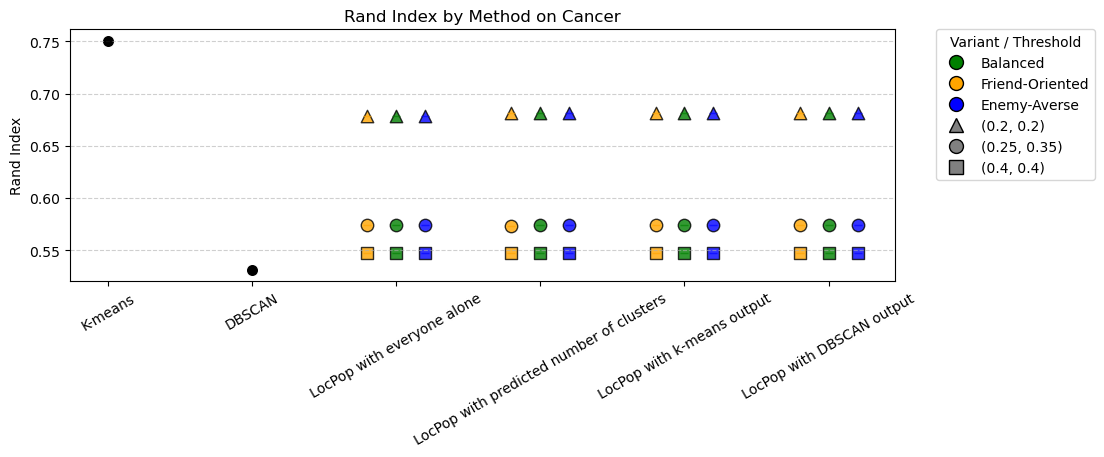

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/cluster/Cancer-Silhouette Score.png


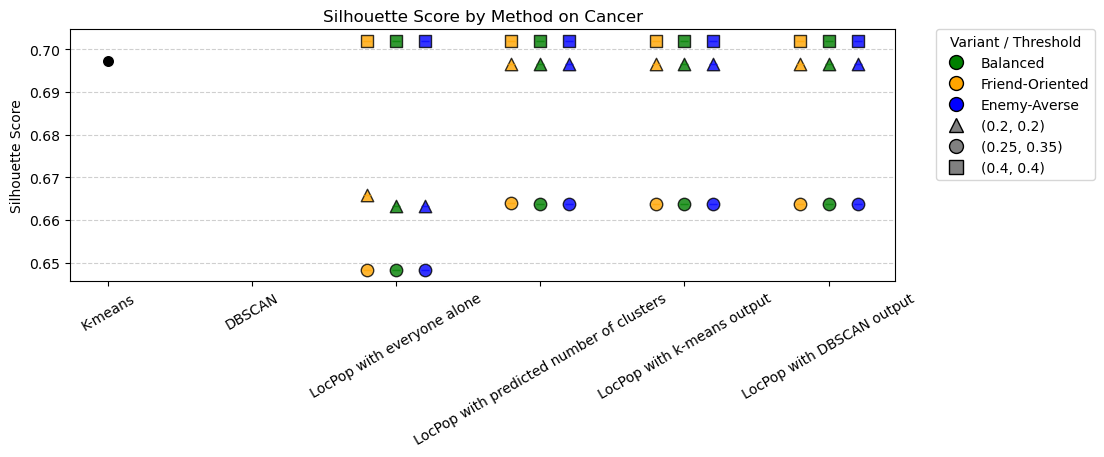

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/cluster/Iris-Rand Index.png


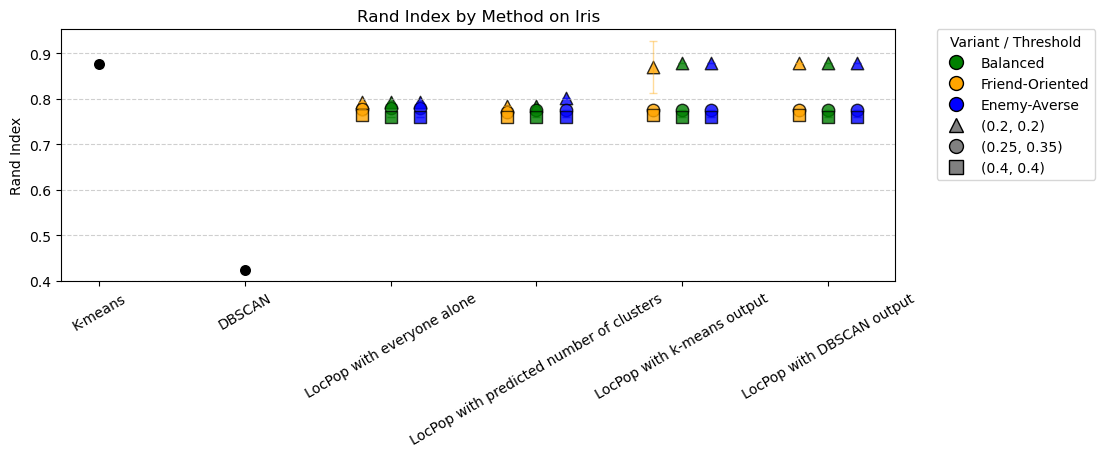

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/cluster/Iris-Silhouette Score.png


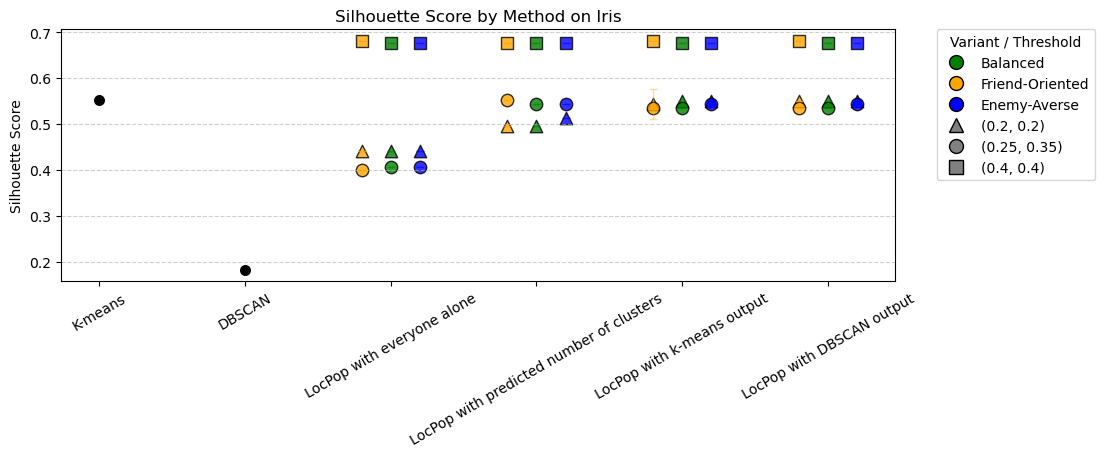

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/cluster/Moons-Rand Index.png


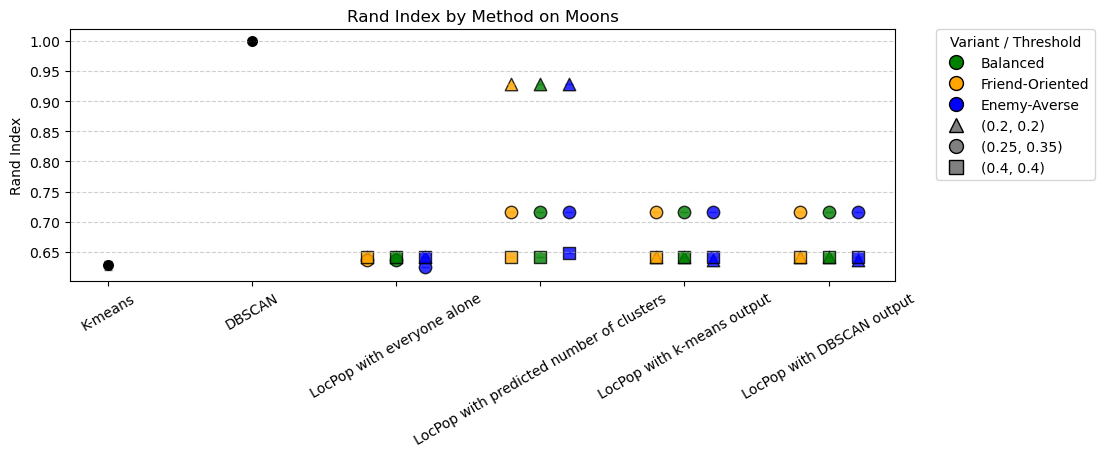

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/cluster/Moons-Silhouette Score.png


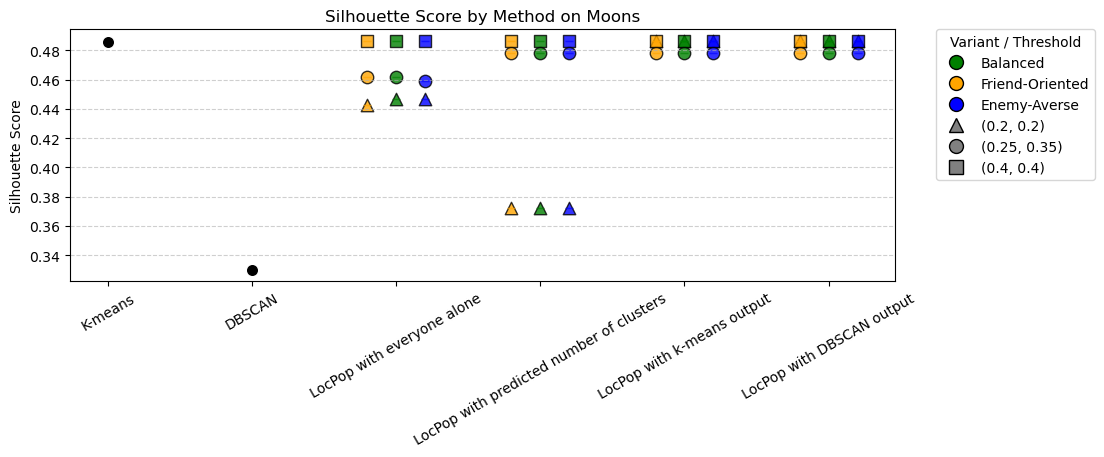

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/cluster/My 3 Circles-Rand Index.png


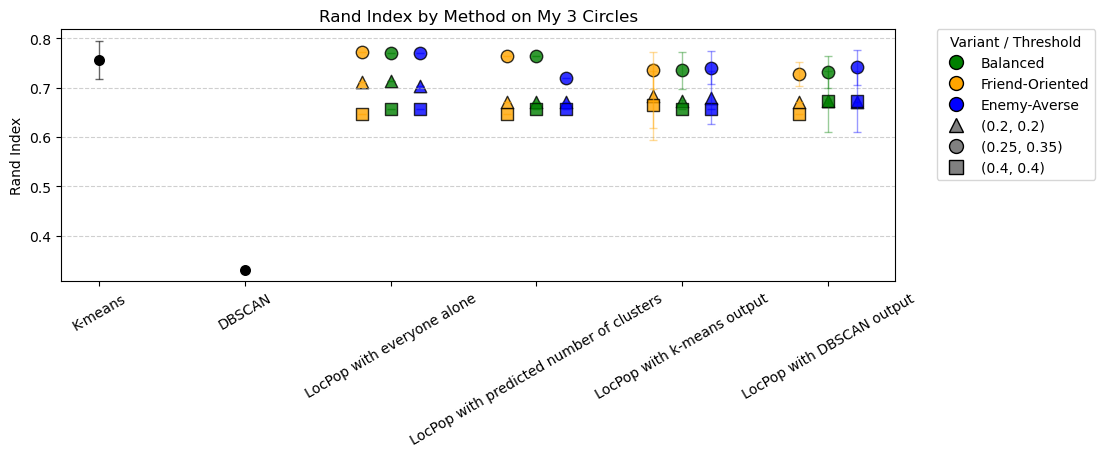

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/cluster/My 3 Circles-Silhouette Score.png


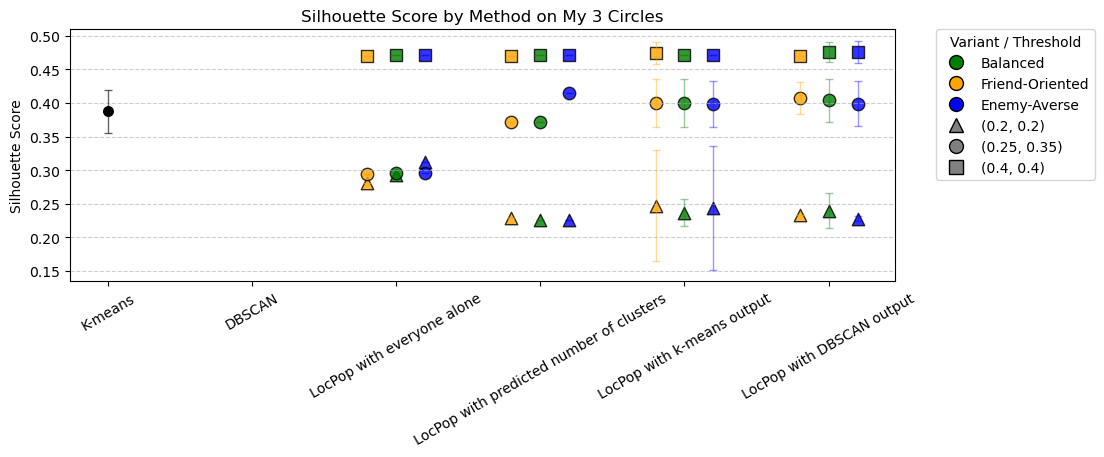

In [225]:
for df in dfs:
    df.replace("n.A.", np.nan, inplace=True)

score_cols = ['Rand Index', 'Silhouette Score']
dfs = [normalize_score_column(df, score_cols) for df in dfs]

# Then call your plotting
for Dataset in ['Cancer', 'Iris', 'Moons', 'My 3 Circles']:
    for score in score_cols:
        plot_and_save(
            dfs, labels, Dataset, score,
            save_path=f'/Users/User/Downloads/local-popular-main-final/noylim/cluster/{Dataset}-{score}.png'
        )